# Engenharia de Atributos
## Projeto desenvolvido por:
### Afonso Rodrigues: 2020242400 <p> Alice Mangara: 2020242411

# Parte A

## Imports and optional data arrangements

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

datapath = 'FacialTracking_Actors_01-24'
nlandmarks = 68

emotion_names=[
    "Neutral",
    "Calm",
    "Happy",
    "Sad",
    "Angry",
    "Fearful",
    "Disgust",
    "Surprised"
    ]

## 2 -- Preparacao do Dataset

### 2.1

In [2]:
def prepareData(files):
    ''' Load data from csv files and save in numpy arrays '''

    # prepare auxiliar arrays
    actors = np.zeros((len(files)), dtype=np.uint8)
    emotions = np.zeros((len(files)), dtype=np.uint8)
    frames = np.zeros((len(files)), dtype=np.uint16)

    all_data = []

    for j in range(len(files)):
        # process video file
        filename = files[j]
        
        # read csv file
        dataset = pd.read_csv(datapath + '/' + filename, sep=',')
        all_data.append(np.array(dataset.loc[:, 'x_0':'y_'+str(nlandmarks-1)]))
        
        # split filename to get aux values
        parts = filename[:-4].split('-')
        actors[j] = int(parts[-1])
        emotions[j] = int(parts[2])     
        frames[j] = len(dataset.index)

    # create 3d array
    data = np.empty(shape=(len(files), nlandmarks*2, 
                           int(np.max(frames))), dtype=np.float32)
    data[:] = np.nan

    # fill the data array
    for i in range(len(files)):
        data[i, :, :int(frames[i])] = all_data[i].T

    return (data, actors, emotions, frames)


# # list files in folder 
# files = os.listdir(datapath)

# # load data
# data, actors, emotions, frames = prepareData(files)

# # save data
# np.save('data.npy', data)
# np.save('actors.npy', actors)
# np.save('emotions.npy', emotions)
# np.save('frames.npy', frames)


### 2.2 + 2.3

In [3]:
def reshapeData(data3d, emotions, actors, frames):
    ''' Convert 3d array into 2d without NaNs '''

    # prepare arrays of data, emotions and actors of shape (n, 136), (n,) and (n,) [being n the sum of all frames]
    data2d = np.empty(shape=(np.sum(frames), data.shape[1]), dtype=np.float32)
    emotions_by_frame = np.empty(shape=(np.sum(frames)), dtype=np.uint8)
    actor_by_frame = np.empty(shape=(np.sum(frames)), dtype=np.uint8)

    k = 0
    for v in range(data3d.shape[0]):
        # gets non nan values of video v
        data2d[k:k+frames[v], :] = data3d[v, :, :frames[v]].T
        
        # fills emotions and actors arrays
        emotions_by_frame[k:k+frames[v]] = emotions[v]
        actor_by_frame[k:k+frames[v]] = actors[v]
        
        # updates k 
        k += frames[v]

    return (data2d, emotions_by_frame, actor_by_frame)


def getData(actor=None, emotion=None, type='2d'):
    ''' Returns data in 2d or 3d shape. if actor is provided, filters data to return that actor. 
    if emotion is provided, filters data to return only that emotion. 
        Cumulative filters, meaning that if both are provided, 
        the intersection of both filters is returned (only videos of that actor with that emotion).'''

    # If 2d is chosen then the program will only take into account all frames singularly
    # If 3d is chosen then 

    data = np.load('data.npy')
    actors = np.load('actors.npy')
    emotions = np.load('emotions.npy')
    frames = np.load('frames.npy')

    if type=='2d':
        # get 2d data
        data, emotions, actors = reshapeData(data, emotions, actors, frames)

        # filter by actor
        if actor is not None:
            data = data[actors == actor,:]
            emotions = emotions[actors == actor]
            actors = actors[actors == actor]
        
        # filter by emotion
        if emotion is not None:
            data = data[emotions == emotion,:]
            actors = actors[emotions == emotion]
            emotions = emotions[emotions == emotion]
            
    
    elif type=='3d':
        # filter by actor
        if actor is not None:
            data = data[actors == actor,:,:]
            emotions = emotions[actors == actor]
            actors = actors[actors == actor]
        
        # filter by emotion
        if emotion is not None:
            data = data[emotions == emotion,:,:]
            actors = actors[emotions == emotion]    
            emotions = emotions[emotions == emotion]
            
    
    return (data, emotions, actors)

In [4]:
# get all data in 3d
data, emotions, actors = getData(type='3d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get all data in 2d
data, emotions, actors = getData(type='2d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get data from actor 1 in 3d
data, emotions, actors = getData(actor=1, type='3d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get data from actor 1 in 2d
data, emotions, actors = getData(actor=1, type='2d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get data from emotion 1 in 3d
data, emotions, actors = getData(emotion=1, type='3d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get data from emotion 1 in 2d
data, emotions, actors = getData(emotion=1, type='2d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get data from actor 1 with emotion 1 in 3d
data, emotions, actors = getData(actor=1, emotion=1, type='3d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())

# get data from actor 1 with emotion 1 in 2d
data, emotions, actors = getData(actor=1, emotion=1, type='2d')
print(data.shape, emotions.shape, actors.shape, np.isnan(data).any())


(2452, 136, 191) (2452,) (2452,) True
(299854, 136) (299854,) (299854,) False
(104, 136, 191) (104,) (104,) True
(12668, 136) (12668,) (12668,) False
(188, 136, 191) (188,) (188,) True
(22458, 136) (22458,) (22458,) False
(8, 136, 191) (8,) (8,) True
(888, 136) (888,) (888,) False


### 2.4

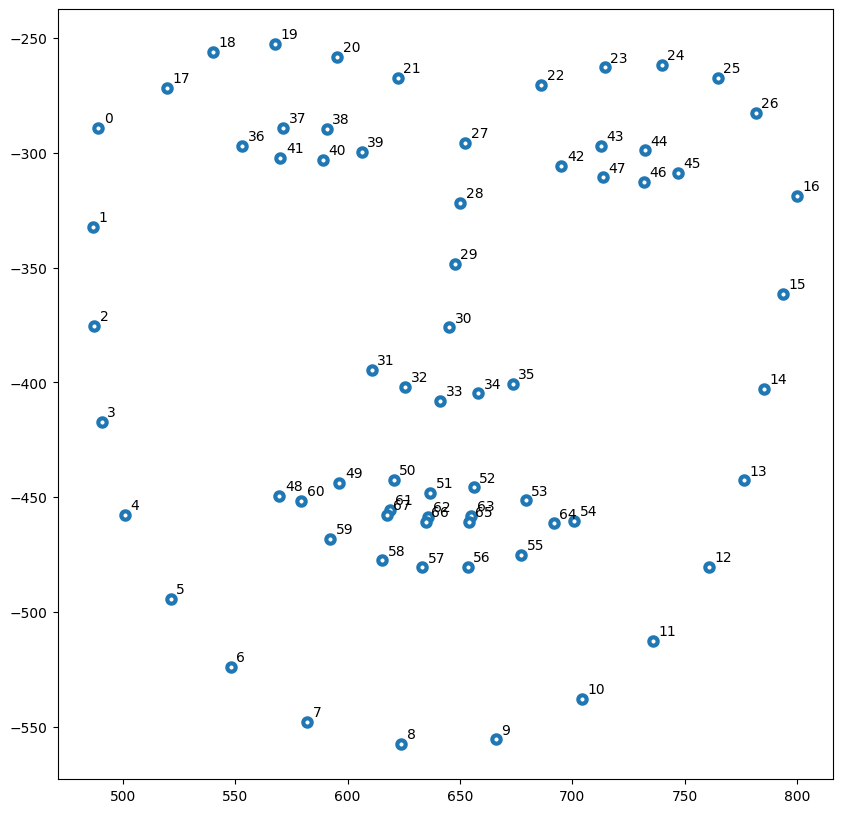

In [5]:
data = np.load('data.npy')

def visualizacao(dados, nlandmarks=68):
    x_coord = dados[0:nlandmarks]
    y_coord = -dados[nlandmarks:nlandmarks*2]
    
    fig = plt.figure(frameon=False, figsize=(10,10))
    ax = plt.axes()
    ax.scatter(x_coord, y_coord,
                edgecolor='#1f77b4',
                linewidths=3,
                c='w')
    for i in range(nlandmarks):
        ax.annotate(text=i, xy=(x_coord[i], y_coord[i]),
                    xytext=(4,4),textcoords='offset points')
        
    plt.show()

if __name__=='__main__':
    actor = 1
    emotion = 1
    frame = 100
    dados, _, _ = getData(actor=actor, emotion=emotion, type='2d')
    dados = dados[frame]
    visualizacao(dados=dados)
    

### Antes de mostrar os vários gráficos normalizámos primeiro os dados a conselho do professor das aulas práticas

## 3 Analise e Tratamento de Outliers

### 3.1 -- Normalizacao de Dados

In [6]:
dataset_total, _, _ = getData(type='2d')
nlandmarks = 68

def normalizacao(dataset, xmax=1280, ymax=720, ref=27):
    x_ref = dataset[:,ref]
    y_ref = dataset[:,ref+nlandmarks]
    for i in range(nlandmarks):
        x_coord = dataset[:,i]
        y_coord = dataset[:,i+nlandmarks]
        if i == 27:
            continue
        dataset[:,i] = (x_coord - x_ref)/xmax  
        dataset[:,i+nlandmarks] = (y_coord - y_ref)/ymax
    dataset[:,ref] = 0
    dataset[:,ref+nlandmarks] = 0
        
    return dataset

### 2.5 -- visualizacao de multiplos graficos

caso seja pedido para mostrar vários atores ou emocoes ao invés de frames então alteramos de *frames para *actor/*emotions

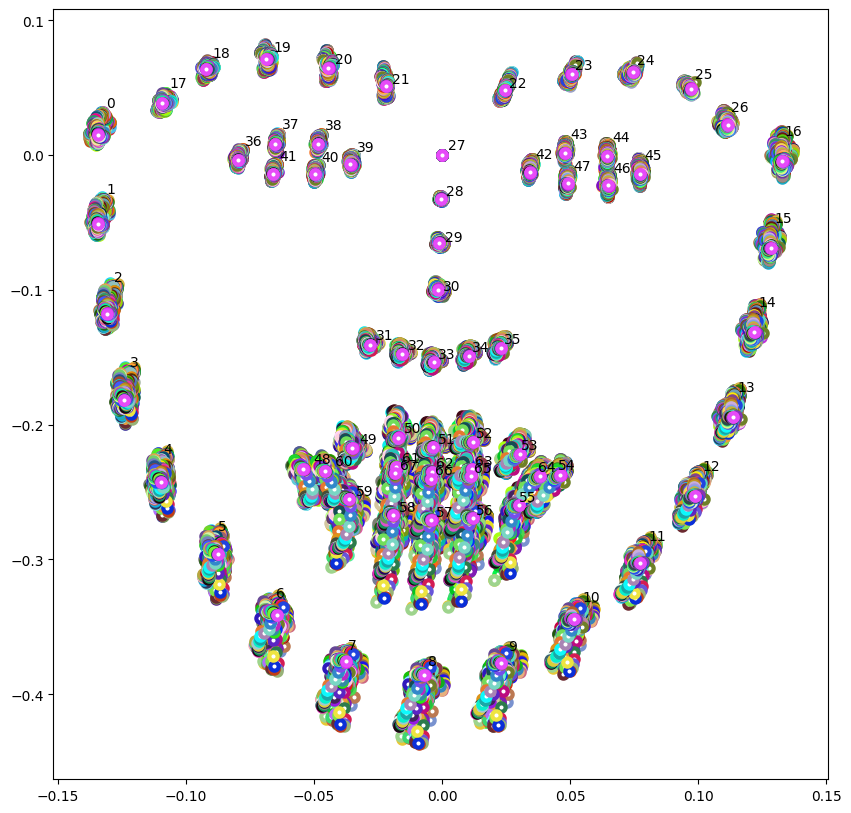

In [7]:
def visualizacao2(dados, actor, emotions, *frames, nlandmarks=68):
    fig = plt.figure(frameon=False, figsize=(10,10))
    ax = plt.axes()
    
    for i, frame_num in enumerate(frames):
        x_coord = dados[frame_num][0:nlandmarks]
        y_coord = -dados[frame_num][nlandmarks:nlandmarks*2]
        
        # Use the specific color for the first frame, and random colors for the rest
        edge_color = '#1f77b4' if i == 0 else np.random.rand(3,)
        
        ax.scatter(x_coord, y_coord,
                   edgecolor=edge_color,
                   linewidths=3,
                   c='w')
        
        if frame_num == frames[0]:
            for j in range(nlandmarks):
                ax.annotate(text=str(j),
                            xy=(x_coord[j], y_coord[j]),
                            xytext=(4,4), textcoords='offset points')
    j = 0
    plt.show()

if __name__ == '__main__':
    actor = 3
    emotion = 1
    dados , _, _ = (getData(actor=actor, emotion=emotion, type='2d'))
    dados = normalizacao(dados)
    frames = np.arange(len(dados))
    visualizacao2(dados, actor, emotion, *frames)


### 3.2 -- Box Plots

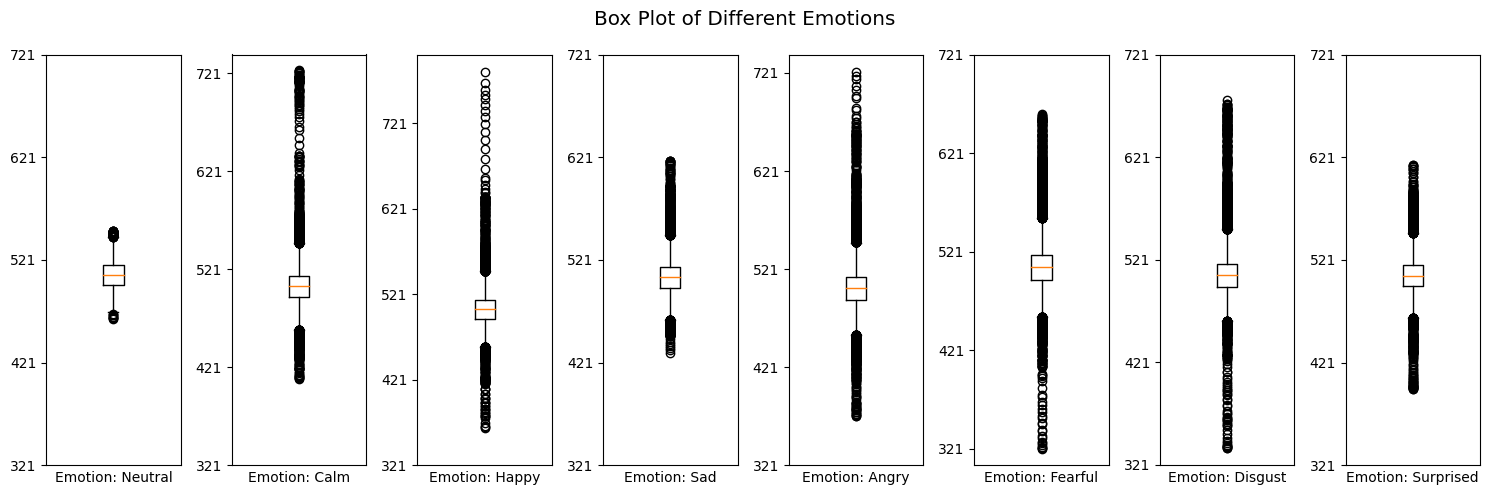

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def emotion_boxplot(coordenada, landmark):
    fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(15, 5))
    fig.suptitle('Box Plot of Different Emotions', fontsize='x-large')

    max_val = float('-inf')
    min_val = float('inf')

    for i in range(8):
        dataset_emotions, _, _ = getData(emotion=i + 1, type='2d')
        
        if coordenada.lower() == 'x':
            dataset_emotions = dataset_emotions[:, landmark]
        elif coordenada.lower() == 'y':
            dataset_emotions = dataset_emotions[:, landmark + 68]

        ax = axs[i]
        ax.boxplot(dataset_emotions)

        temp_max = np.max(dataset_emotions)
        temp_min = np.min(dataset_emotions)

        if temp_max > max_val:
            max_val = temp_max
        if temp_min < min_val:
            min_val = temp_min
        ax.set_xlabel(f'Emotion: {emotion_names[i]}')

    for ax in axs:
        ax.set_yticks(np.arange(round(min_val), round(max_val), 100))  # Set y-ticks for all subplots
        ax.set_xticks([])
        
    plt.tight_layout()
    plt.show()

# Call the function
emotion_boxplot('x', 4)


### 3.3 -- Densidade de Outliers

In [9]:
def outlier_function(data):
    counter = 0
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for x in data:
        if x < lower_bound or x > upper_bound:
            counter += 1
    return counter

def density_function(outlier_count, total_count):
    return (outlier_count/total_count)*100
    

In [10]:
outliers = np.empty(shape=(8, 
                        nlandmarks*2), dtype=np.float32)
outliers[:] = np.nan

for e in range(8):
    dataset_emotions, _,_ = getData(emotion=e+1, type='2d')
    dataset_emotions = normalizacao(dataset_emotions)
    for i in range(nlandmarks*2):
        outliers[e, i] = density_function(outlier_function(dataset_emotions[:,i]),
                                          len(dataset_emotions[:,i]))

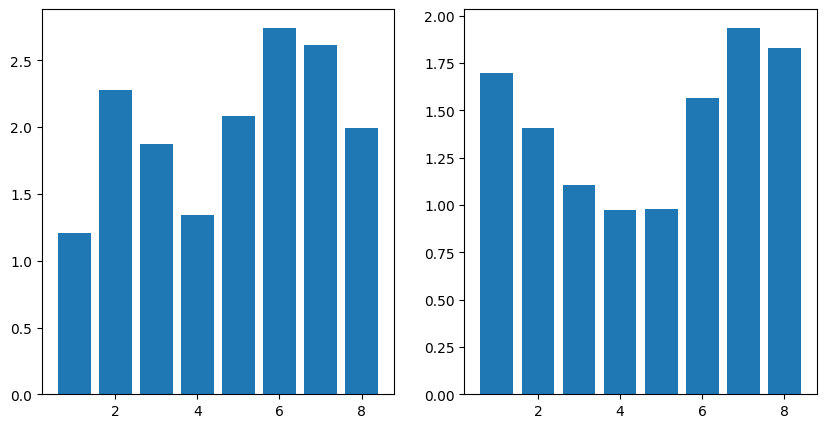

In [11]:
valor_medio_outliers = [np.mean(x) for x in outliers]
desvio_padrao_outliers = [np.std(x) for x in outliers]

label = np.arange(1,9)

fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].bar(label, valor_medio_outliers)
axs[1].bar(label, desvio_padrao_outliers)
plt.show()

Ao visualizarmos através de um gráfico de barras a distribuição da média e do desvio padrão dos outliers, de acordo com o IQR, podemos verificar que
- as emoções 6 e 7 são as que têm mais outliers em média
- as emoções 7 e 8 são as cujo outlier tem o maior desvio padrão <p>
com isto, tiramos a conclusão que, a emoção 7 é aquela com mais outliers, bem como, aquela com maior dispersão de dados, daí o grande pico no desvio padrão

### 3.4 e 3.5

#### Descoberta de Outliers usando o teste Z-Score

In [12]:
def z_score(k, data):
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    index = []
    for i, o in enumerate(data):
        z = (o-mean)/std
        if abs(z) > k:
            index.append(i)
            outliers.append(o)
            
    return outliers, index

C:\Users\Afonso Rodrigues\AppData\Local\Temp\ipykernel_17268\3345282945.py:7: RuntimeWarning: invalid value encountered in scalar divide
  z = (o-mean)/std


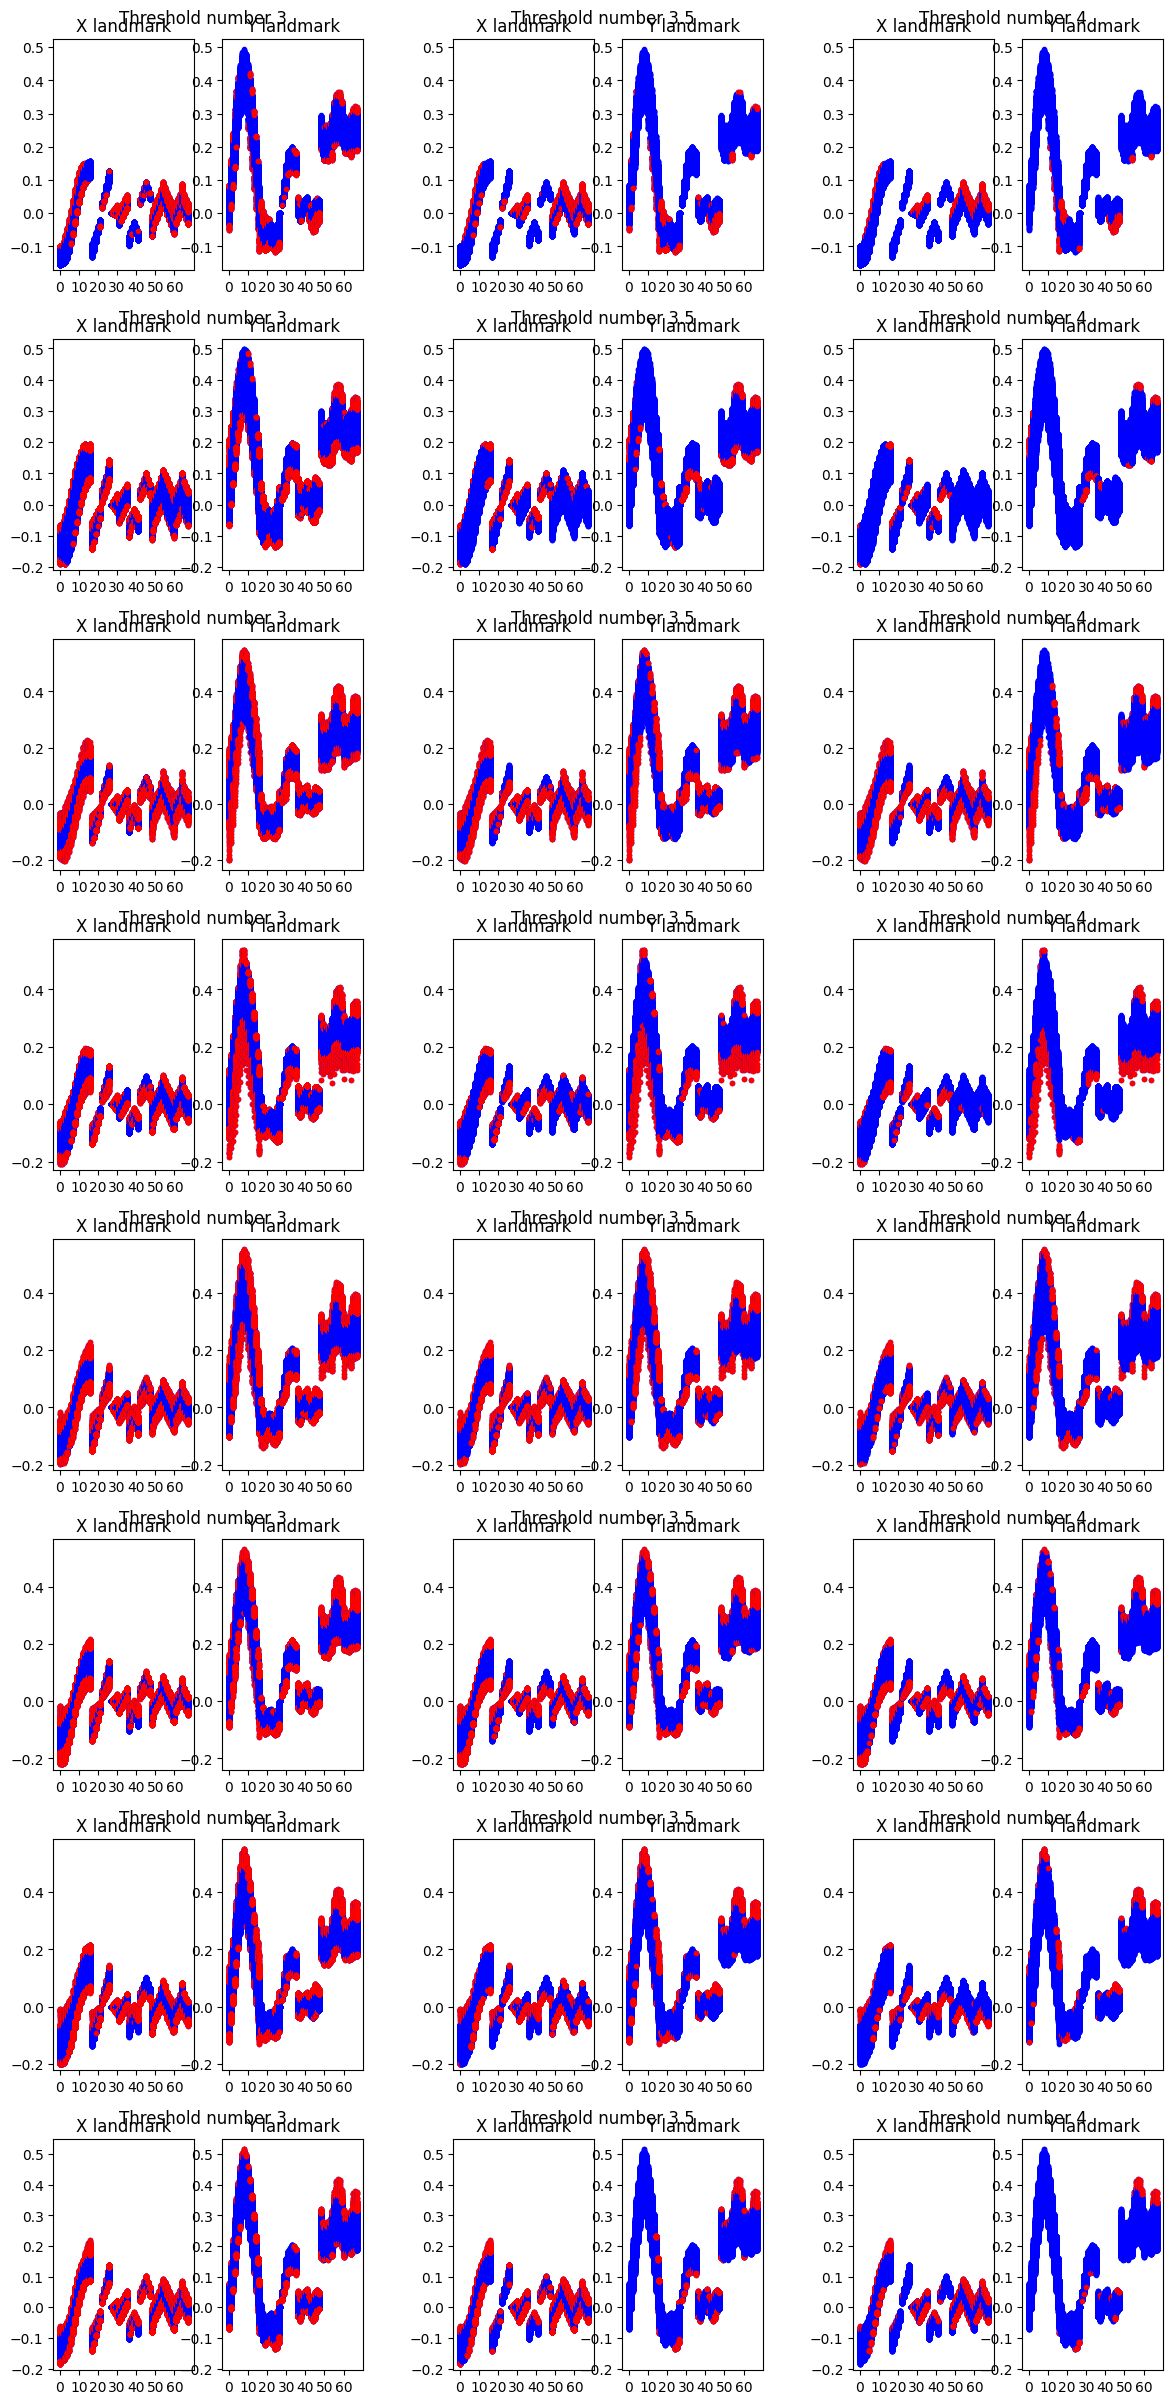

In [13]:
fig = plt.figure(figsize=(12,24))
subfigs = fig.subfigures(8,3)

thresholds = [3, 3.5, 4]

for row,subfig_row in enumerate(subfigs):
    for col, subfig in enumerate(subfig_row):
        
        dataset_emotions, _,_ = getData(emotion=row+1, type='2d')
        dataset_emotions = normalizacao(dataset_emotions)
        subfig.suptitle(f'Threshold number {thresholds[col]}')
        axs = subfig.subplots(1,2)
        # ax.set_title(f'Dot Plot of emotion i')
        for i in range(136):
            dzscore, _ = z_score(thresholds[col],dataset_emotions[:,i])
            if i <68:
                axs[0].plot(np.full_like(dataset_emotions[:,i],i), dataset_emotions[:,i], 'b.')
                axs[0].plot(np.full_like(dzscore,i), dzscore, 'r.')
            else:
                axs[1].plot(np.full_like(dataset_emotions[:,i],i-68), dataset_emotions[:,i], 'b.')
                axs[1].plot(np.full_like(dzscore,i-68), dzscore, 'r.')

        x_arange = np.arange(0, 68, 10)

        y_min = min([axs[i].get_ylim()[0] for i in range(2)])
        y_max = max([axs[i].get_ylim()[1] for i in range(2)])

        title_landmarks = ['X landmark', 'Y landmark']

        for i in range(2):
            axs[i].set_ylim(y_min, y_max)
            axs[i].set_xticks(x_arange)
            axs[i].set_xticklabels([str(val) for val in x_arange]);
            axs[i].set_title(f'{title_landmarks[i]}')


#### 3.6
Ao analisar os resultados do boxplot em 3.2, conseguimos verificar que as emoções 2, 3, 6 e 7 são as que apresentam maior disparidade entre os outliers (como ja foi explicado umas alíneas acima) <p>
Em contraste com o exercício 3.5, no qual utilizamos o método de deteção de outliers Z-Score, ao invés do natural IQR do boxplot, podemos verificar visualmente nas coordenadas X e Y da emoção 3 (linha 3) que temos imensos pontos analisados a vermelho ao longo de todo o gráfico, mais espeficicamente nas coordenadas 0-5 do landmark Y, são verificados outliers desde -0.2 a 0.0 (cerca de 20% da escala). Com isto conseguimos confirmar o que o boxplot nos apresentava.<p>
Em contrário, verificamos na emoção 1, no boxplot, uma baixa variabilidade nos outliers, logo, como seria de esperar, verificamos também no Dot Plot do 3.5, apesar da existência de outliers na emoção 1, é verificada uma pequena variabilidade deles.

### 3.7

#### Utilizamos a Distância Euclideana uma vez que neste caso, as features que temos são numéricas e não categóricas <p> Tentámos também maximizar a distância de clusters, pelo Dunn Index, de forma a conseguirmos clusters mais separados e uniformes obtendo, por conseguinte, um melhor K-Means Clustering, no entanto, o Kernel acabava sempre por crashar independentemente do trabalho relacionado

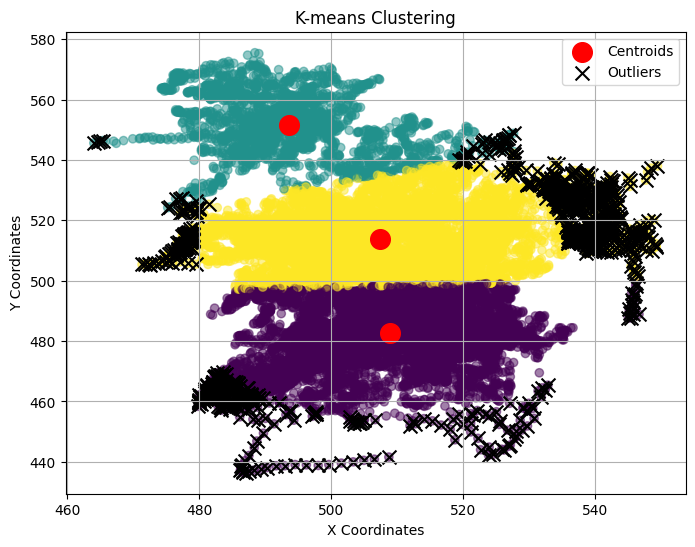

In [14]:
def kmeans(dataset, landmark, k, max_iters=200):
    data1 = dataset[:, landmark]
    data2 = dataset[:, landmark + 68]
    data = np.column_stack((data1, data2))
    
    centroids = data[np.random.choice(len(data), k, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    # -- Outlier Detection
        
    # Distance_point -> distância de uma ponto a um threshold
    # Distance threshold -> média + 3* desvio padrao
    
    distance_point = np.min(distances, axis=1)
    distance_threshold = np.mean(distance_point) + 2* np.std(distance_point)
    
    # Definimos outliers quando distance_point > distance_threshold
    outliers_indices = np.where(distance_point > distance_threshold)
    return centroids, labels, outliers_indices

dataset,_,_ = getData(emotion=1,)
landmark = 4
k = 3
centroids, cluster_labels, outliers = kmeans(dataset, landmark, k)

plt.figure(figsize=(8, 6))

# Plot dos pontos na totalidade
plt.scatter(dataset[:, landmark], 
            dataset[:, landmark + 68], 
            c=cluster_labels, cmap='viridis', alpha=0.5)

# Plot dos centroides após serem adaptados e fixados
plt.scatter(centroids[:, 0], 
            centroids[:, 1], 
            c='red', marker='o', s=200, label='Centroids')

# Plot dos outliers
plt.scatter(dataset[outliers, landmark], 
            dataset[outliers, landmark + 68], c='black', marker='x', s=100, label='Outliers')

plt.title('K-means Clustering')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
print(len(outliers[0]))
print(len(dataset_total))

987
299854


### 3.9 Injecao de outliers

In [16]:
def count_outliers(dataset, k):
    mean = np.mean(dataset)
    std = np.std(dataset)
    length = len(dataset)
    lower_bound = mean - k * std
    upper_bound = mean + k * std
    
    outside_count = sum(1 for x in dataset if x < lower_bound or x > upper_bound)
    
    return (outside_count)
        

max(z_score(3,dataset)[0]) pq a funcao z score devolve valor do outlier e index dele

In [17]:
def transformacao_non_outlier(dataset, k):
    mean = np.mean(dataset)
    std = np.std(dataset)
    
    lower_q_bound = 0
    upper_q_bound = max(z_score(3,dataset)[0])
    s = random.uniform(-1,1)
    
    q = 0
    if upper_q_bound > 0:
        q = random.uniform(lower_q_bound, upper_q_bound)
    
    p = mean + s*k*std + q
    return p

In [18]:
def outlier_injection(dataset, k, x):
    all_indices = set(range(len(dataset)))
    dados = dataset.copy()
    _, outlier_indices = z_score(k, dados)
    outlier_indices = set(outlier_indices)
    index_changed = set()

    non_outlier_indices = list(all_indices - outlier_indices)
    num_outliers = len(outlier_indices)
    num_total = len(all_indices)
    outlier_ratio = (num_outliers / num_total) * 100

    while outlier_ratio < x:
        try:
            random_index = random.choice(non_outlier_indices)
            dados[random_index] = transformacao_non_outlier(dados, k)
            outlier_indices.add(random_index)
            index_changed.add(random_index)
            non_outlier_indices.remove(random_index)
            num_outliers += 1
            outlier_ratio = (num_outliers / num_total) * 100
        except ValueError:
            continue

    return dados, index_changed

### 3.10

In [19]:
from numpy.linalg import inv

def linear_model(X, y):
    weights = np.linalg.inv(X.T @ X) @ X.T @ y
    return weights

#### X_transformado @ weights devolve-nos o y

### 3.11

#### Nao sei oq esta de mal mas tive que remover os ultimos 9 elementos para nao causar erro na funcao

In [20]:
def prepare_data(data, p):
    X, y = [], []
    for i in range(p, len(data)):
        X.append(data[i-p:i].tolist())
        y.append(data[i])
    
    X = np.insert(X, 0, 1, axis=1)  # Add a column of 1s to the left of X
    return X, np.array(y)


In [21]:
dados, _, _= getData(emotion=1, type='2d')
y_landmark_57 = dados[:,57]
p = 10
X,y = prepare_data(y_landmark_57, p)
weights = linear_model(X,y)
print(weights)
dataset_post_inject, indexes = outlier_injection(y_landmark_57, 3, 5)

for index in indexes:
    dataset_post_inject[index] = y[index]

[ 8.19216330e+00 -3.71332856e-03  2.90975060e-03 -8.85769459e-05
  9.38046903e-04  1.41484048e-03 -6.66005076e-03 -1.92569056e-02
 -3.61371360e-02 -5.34822766e-02  1.10130303e+00]


#### Análise das métricas do 3.11

MAE: 0.5903703969089666
MSE: 2.8865946128622273
RMSE: 1.6989981203233355
R2 Score: 0.9798519566475169


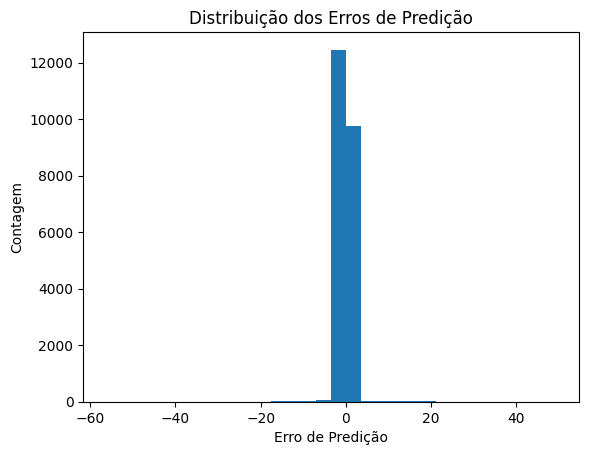

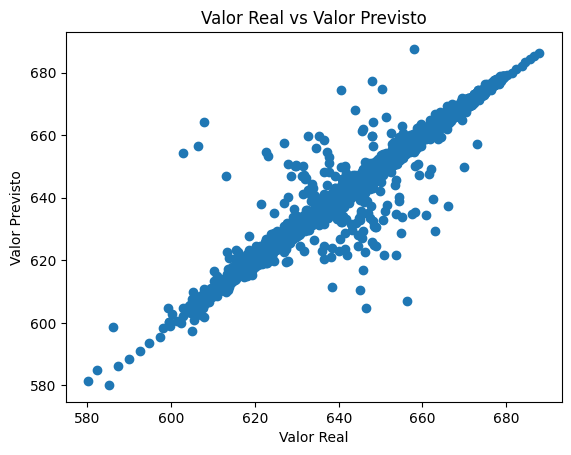

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Predição do modelo
y_pred = X @ weights

# Cálculo das métricas de erro
mae = mean_absolute_error(y_landmark_57[p:], y_pred)
mse = mean_squared_error(y_landmark_57[p:], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_landmark_57[p:], y_pred)

# Print das métricas
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2 Score:', r2)

# Plot da distribuição dos erros
plt.hist(y_landmark_57[p:] - y_pred, bins=30)
plt.xlabel('Erro de Predição')
plt.ylabel('Contagem')
plt.title('Distribuição dos Erros de Predição')
plt.show()

# Plot do valor real vs valor previsto
plt.scatter(y_landmark_57[p:], y_pred)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Valor Real vs Valor Previsto')
plt.show()


In [23]:
best_p = None
best_rmse = np.inf

for p in range(1, 21):  # Testar valores de p de 1 a 20
    X, y = prepare_data(y_landmark_57, p)
    weights = linear_model(X, y)
    y_pred = X @ weights
    rmse = np.sqrt(mean_squared_error(y_landmark_57[p:], y_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_p = p

print('Melhor p:', best_p)
print('RMSE correspondente:', best_rmse)


Melhor p: 4
RMSE correspondente: 1.6988293742168181


### 3.12

In [24]:
def prepare_data_centered(data, p):
    X, y = [], []
    half_p = p // 2
    for i in range(half_p, len(data) - half_p):
        X.append(data[i-half_p:i] + data[i+1:i+half_p+1].tolist())
        y.append(data[i])
    
    X = np.insert(X, 0, 1, axis=1)  # Add a column of 1s to the left of X
    return X, np.array(y)


In [27]:
dados, _, _= getData(emotion=1, type='2d')
y_landmark_57 = dados[:,57]
p = 10
X,y = prepare_data_centered(y_landmark_57, p)
weights = linear_model(X,y)
print(weights)
dataset_post_inject, indexes = outlier_injection(y_landmark_57, 3, 5)

for index in indexes:
    dataset_post_inject[index] = y[index]

[-1.02555182e+01  2.56659882e-01 -9.06810194e-04 -3.46862554e-03
 -9.16944542e-04  2.56627442e-01]


MAE: 0.9445587655423802
MSE: 3.3384221394869753
RMSE: 1.8271349538244228
R2 Score: 0.9767015947618589


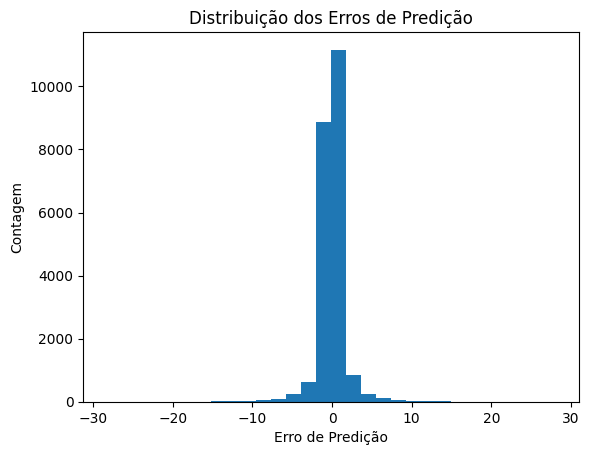

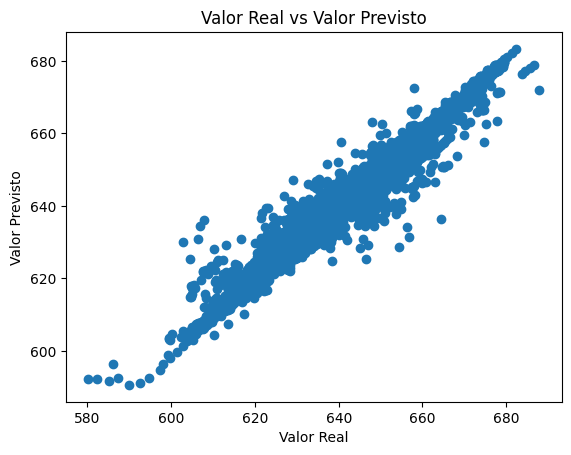

In [28]:
# Predição do modelo
half_p = p//2

y_pred = X @ weights

# Cálculo das métricas de erro
mae = mean_absolute_error(y_landmark_57[half_p:-half_p], y_pred)
mse = mean_squared_error(y_landmark_57[half_p:-half_p], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_landmark_57[half_p:-half_p], y_pred)

# Print das métricas
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2 Score:', r2)

# Plot da distribuição dos erros
plt.hist(y_landmark_57[half_p:-half_p] - y_pred, bins=30)
plt.xlabel('Erro de Predição')
plt.ylabel('Contagem')
plt.title('Distribuição dos Erros de Predição')
plt.show()

# Plot do valor real vs valor previsto
plt.scatter(y_landmark_57[half_p:-half_p], y_pred)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Valor Real vs Valor Previsto')
plt.show()


In [29]:
best_p = None
best_rmse = np.inf

for p in range(2, 22):  # Testar valores de p de 1 a 20 
    half_p = p//2
    X, y = prepare_data_centered(y_landmark_57, p)
    weights = linear_model(X, y)
    y_pred = X @ weights
    rmse = np.sqrt(mean_squared_error(y_landmark_57[half_p:-half_p], y_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_p = p

print('Melhor p:', best_p)
print('RMSE correspondente:', best_rmse)


Melhor p: 2
RMSE correspondente: 1.1430772547936023


#### Ao vermos os valores usando uma sliding window dos p anteriores no 3.11, verificamos que com p=4 obtemos os melhores valores, isto é, o menor RMSE <p> Porém, no 3.12, ao utilizarmos p/2 valores anteriores e seguintes, descobrimos que quanto menos p melhor, obtendo o menor RMSE logo no primeiro p=2. Consideramos o primeiro como p=2 e não p=1, porque será dividido na janela em 1 para a esquerda e 1 para a direita

## 4

### 4.1 

Os pontos de interesse escolhidos foram
- 27 por ser o ponto de referência usado anteriormente, bem como, o ponto "central" da cara
- 17, 21, 22, 26 por serem as coordenadas dos pontos extremos das sobrancelhas
- 48, 54 por serem os cantos extremos da boca
- 56, 57, 58 por serem as coordenadas dos lábios inferiores


In [30]:
import numpy as np
from scipy.spatial import distance
video, _, _ = getData(type='3d')
landmarks_of_interest = [17,21,22,26,27,48,54,56,57,58]

#### 4.1.1 

In [31]:
def calculate_mean_positions(dataset, landmarks_of_interest):
    nlandmarks = 68
    mean_positions = []
    
    for i in landmarks_of_interest:
        x_loi = np.nanmean(dataset[:, i], axis=1)
        y_loi = np.nanmean(dataset[:, i+nlandmarks], axis=1)
        
        mean_positions.append(x_loi)
        mean_positions.append(y_loi)
    
    return mean_positions

def create_dataframe(dataset,frames, landmarks_of_interest):
    mean_positions = calculate_mean_positions(video, landmarks_of_interest)
    
    df = pd.DataFrame(np.array(mean_positions).T)
    df.columns = ['x_mean_' + str(i) for i in landmarks_of_interest] + ['y_mean_' + str(i) for i in landmarks_of_interest]
    
    return df

dataset, emotions, actors = getData(type='3d')
video, _, _ = getData(type='3d')

df = create_dataframe(video, frames, landmarks_of_interest)
df.head(5)


,x_mean_17,x_mean_21,x_mean_22,x_mean_26,x_mean_27,x_mean_48,x_mean_54,x_mean_56,x_mean_57,x_mean_58,y_mean_17,y_mean_21,y_mean_22,y_mean_26,y_mean_27,y_mean_48,y_mean_54,y_mean_56,y_mean_57,y_mean_58
0,499.956116,276.903076,596.393860,263.701019,659.689758,261.963257,761.264282,266.878540,626.623474,290.180603,561.775574,451.678558,690.260193,452.846924,641.552002,479.859161,621.461243,481.779572,603.836792,480.095917
1,492.957794,312.977997,597.442261,302.270630,666.654114,300.211945,762.766052,300.149536,635.366028,338.501831,581.532104,503.511902,697.279846,499.533020,659.706360,529.272461,642.319214,531.206421,625.520142,529.866943
2,519.741760,299.641724,630.262146,292.758240,689.424316,295.291260,799.791260,311.918457,658.114563,330.068939,589.638855,497.641724,713.001953,501.889313,670.509705,529.594116,650.574707,530.575745,632.130066,527.655273
3,511.977814,253.958588,609.078796,242.596985,673.572693,248.182831,765.487854,267.806061,640.437378,290.918152,565.997009,452.584839,691.297974,459.695953,643.443420,487.066650,624.379822,487.290924,606.712158,484.822205
4,505.012939,269.983337,618.141724,246.688889,684.894470,249.296295,801.500000,272.484253,652.584290,293.712036,583.957397,490.532410,723.414856,491.379608,671.435181,524.529663,650.773987,526.310181,631.513916,524.380554


#### 4.1.2

In [32]:
def calculate_angle_vectorized(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def calculate_area_vectorized(x1, y1, x2, y2, x3, y3):
    return 0.5 * np.abs((x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)))

def calculate_distance_vectorized(x1, y1, x2, y2):
    return np.linalg.norm(np.array([x2 - x1, y2 - y1]), axis=0)


In [33]:
def calculate_statistics(video, landmarks_of_interest):
    nlandmarks = 68
    statistics = []

    for video_num in range(video.shape[0]):  
        angle = []
        area = []
        distance = []
        
        for frame in range(video.shape[2]):
            # Obtenha as coordenadas x e y para os landmarks de interesse
            x = video[video_num, landmarks_of_interest, frame]
            y = video[video_num, [i + nlandmarks for i in landmarks_of_interest], frame]

            # Calculate angles, areas, and distances using vectorized operations
            angle.extend(calculate_angle_vectorized(x[:-1], y[:-1], x[1:], y[1:]))
            area.extend(calculate_area_vectorized(x[:-2], y[:-2], x[1:-1], y[1:-1], x[2:], y[2:]))
            distance.extend(calculate_distance_vectorized(x[:-1], y[:-1], x[1:], y[1:]))

        video_statistics = [
            np.nanmean(angle), np.nanstd(angle), np.nanmin(angle), np.nanmax(angle),
            np.nanmean(area), np.nanstd(area), np.nanmin(area), np.nanmax(area),
            np.nanmean(distance), np.nanstd(distance), np.nanmin(distance), np.nanmax(distance)
        ]

        statistics.append(video_statistics)
    
    return statistics


def create_dataframe1(video, frames, landmarks_of_interest):
    statistics = calculate_statistics(video, landmarks_of_interest)

    df1 = pd.DataFrame(statistics, columns=[
        'angle_mean', 'angle_std', 'angle_min', 'angle_max',
        'area_mean', 'area_std', 'area_min', 'area_max',
        'distance_mean', 'distance_std', 'distance_min', 'distance_max'
    ])

    return df1
df1 = create_dataframe1(video,frames, landmarks_of_interest)
df1.head(5)


,angle_mean,angle_std,angle_min,angle_max,area_mean,area_std,area_min,area_max,distance_mean,distance_std,distance_min,distance_max
0,47.455589,108.090446,-178.363419,178.602814,3087.082275,4203.782715,25.840179,10894.382812,88.450211,50.525661,16.819025,179.489548
1,44.656536,106.229202,-177.101242,174.838806,2876.745361,3859.521240,9.274658,9962.680664,86.157448,49.957085,15.247247,180.446228
2,49.729359,106.741905,-172.092819,177.867584,3335.554932,4411.541016,31.400192,12200.945312,90.943634,53.328888,17.410643,191.171127
3,36.858414,112.605911,-179.706146,180.000000,3136.695312,3942.437744,19.039757,10781.699219,86.647095,50.017792,16.901192,191.832153
4,47.955429,107.417053,-175.056870,175.815063,4356.833496,5555.634277,30.800690,14656.738281,100.163849,59.472412,18.189257,215.369934


#### 4.1.3

In [34]:
def calculate_statistics(video, landmarks_of_interest):
    nlandmarks = 68
    statistics = []

    for video_num in range(video.shape[0]):  
        x_diffs = []
        y_diffs = []
        
        for frame in range(1, video.shape[2]):
            for i in landmarks_of_interest:
                
                x_current = video[video_num, i, frame]
                y_current = video[video_num, i+nlandmarks, frame]
                x_prev = video[video_num, i, frame-1]
                y_prev = video[video_num, i+nlandmarks, frame-1]

                # Calculate the differences (velocities) for the current and previous frames
                x_diff = x_current - x_prev
                y_diff = y_current - y_prev
                x_diffs.append(x_diff)
                y_diffs.append(y_diff)

        video_statistics = [
            np.nanmean(x_diffs), np.nanstd(x_diffs), np.nanmin(x_diffs), np.nanmax(x_diffs),
            np.nanmean(y_diffs), np.nanstd(y_diffs), np.nanmin(y_diffs), np.nanmax(y_diffs),
        ]

        statistics.append(video_statistics)
    
    return statistics
def create_dataframe2(video, frames, landmarks_of_interest):
    statistics = calculate_statistics(video, landmarks_of_interest)
    df2 = pd.DataFrame(statistics, columns=[
        'x_diff_mean', 'x_diff_std', 'x_diff_min', 'x_diff_max',
        'y_diff_mean', 'y_diff_std', 'y_diff_min', 'y_diff_max'
    ])

    return df2

df2 = create_dataframe2(video,frames, landmarks_of_interest)
df2.head(5)


,x_diff_mean,x_diff_std,x_diff_min,x_diff_max,y_diff_mean,y_diff_std,y_diff_min,y_diff_max
0,-0.321650,0.811913,-6.200012,2.100037,0.100618,1.329715,-9.899994,10.600006
1,-0.152407,0.687760,-4.000000,5.099976,0.137778,1.830958,-7.700012,10.700012
2,-0.039019,0.604580,-4.400024,3.500000,-0.104804,1.971355,-10.200012,13.000000
3,-0.034592,0.698933,-5.599976,5.099976,-0.089796,1.863839,-10.600006,13.199982
4,0.021869,0.359007,-1.400024,2.200012,-0.023084,1.201324,-6.500000,6.400024


In [35]:
final_features = pd.concat([df, df1, df2], axis=1)
final_features.head(5)

,x_mean_17,x_mean_21,x_mean_22,x_mean_26,x_mean_27,x_mean_48,x_mean_54,x_mean_56,x_mean_57,x_mean_58,...,distance_min,distance_max,x_diff_mean,x_diff_std,x_diff_min,x_diff_max,y_diff_mean,y_diff_std,y_diff_min,y_diff_max
0,499.956116,276.903076,596.393860,263.701019,659.689758,261.963257,761.264282,266.878540,626.623474,290.180603,...,16.819025,179.489548,-0.321650,0.811913,-6.200012,2.100037,0.100618,1.329715,-9.899994,10.600006
1,492.957794,312.977997,597.442261,302.270630,666.654114,300.211945,762.766052,300.149536,635.366028,338.501831,...,15.247247,180.446228,-0.152407,0.687760,-4.000000,5.099976,0.137778,1.830958,-7.700012,10.700012
2,519.741760,299.641724,630.262146,292.758240,689.424316,295.291260,799.791260,311.918457,658.114563,330.068939,...,17.410643,191.171127,-0.039019,0.604580,-4.400024,3.500000,-0.104804,1.971355,-10.200012,13.000000
3,511.977814,253.958588,609.078796,242.596985,673.572693,248.182831,765.487854,267.806061,640.437378,290.918152,...,16.901192,191.832153,-0.034592,0.698933,-5.599976,5.099976,-0.089796,1.863839,-10.600006,13.199982
4,505.012939,269.983337,618.141724,246.688889,684.894470,249.296295,801.500000,272.484253,652.584290,293.712036,...,18.189257,215.369934,0.021869,0.359007,-1.400024,2.200012,-0.023084,1.201324,-6.500000,6.400024


In [36]:
_, emotions, _ = getData(type='3d')
final_features['emotions'] = emotions

### 4.2

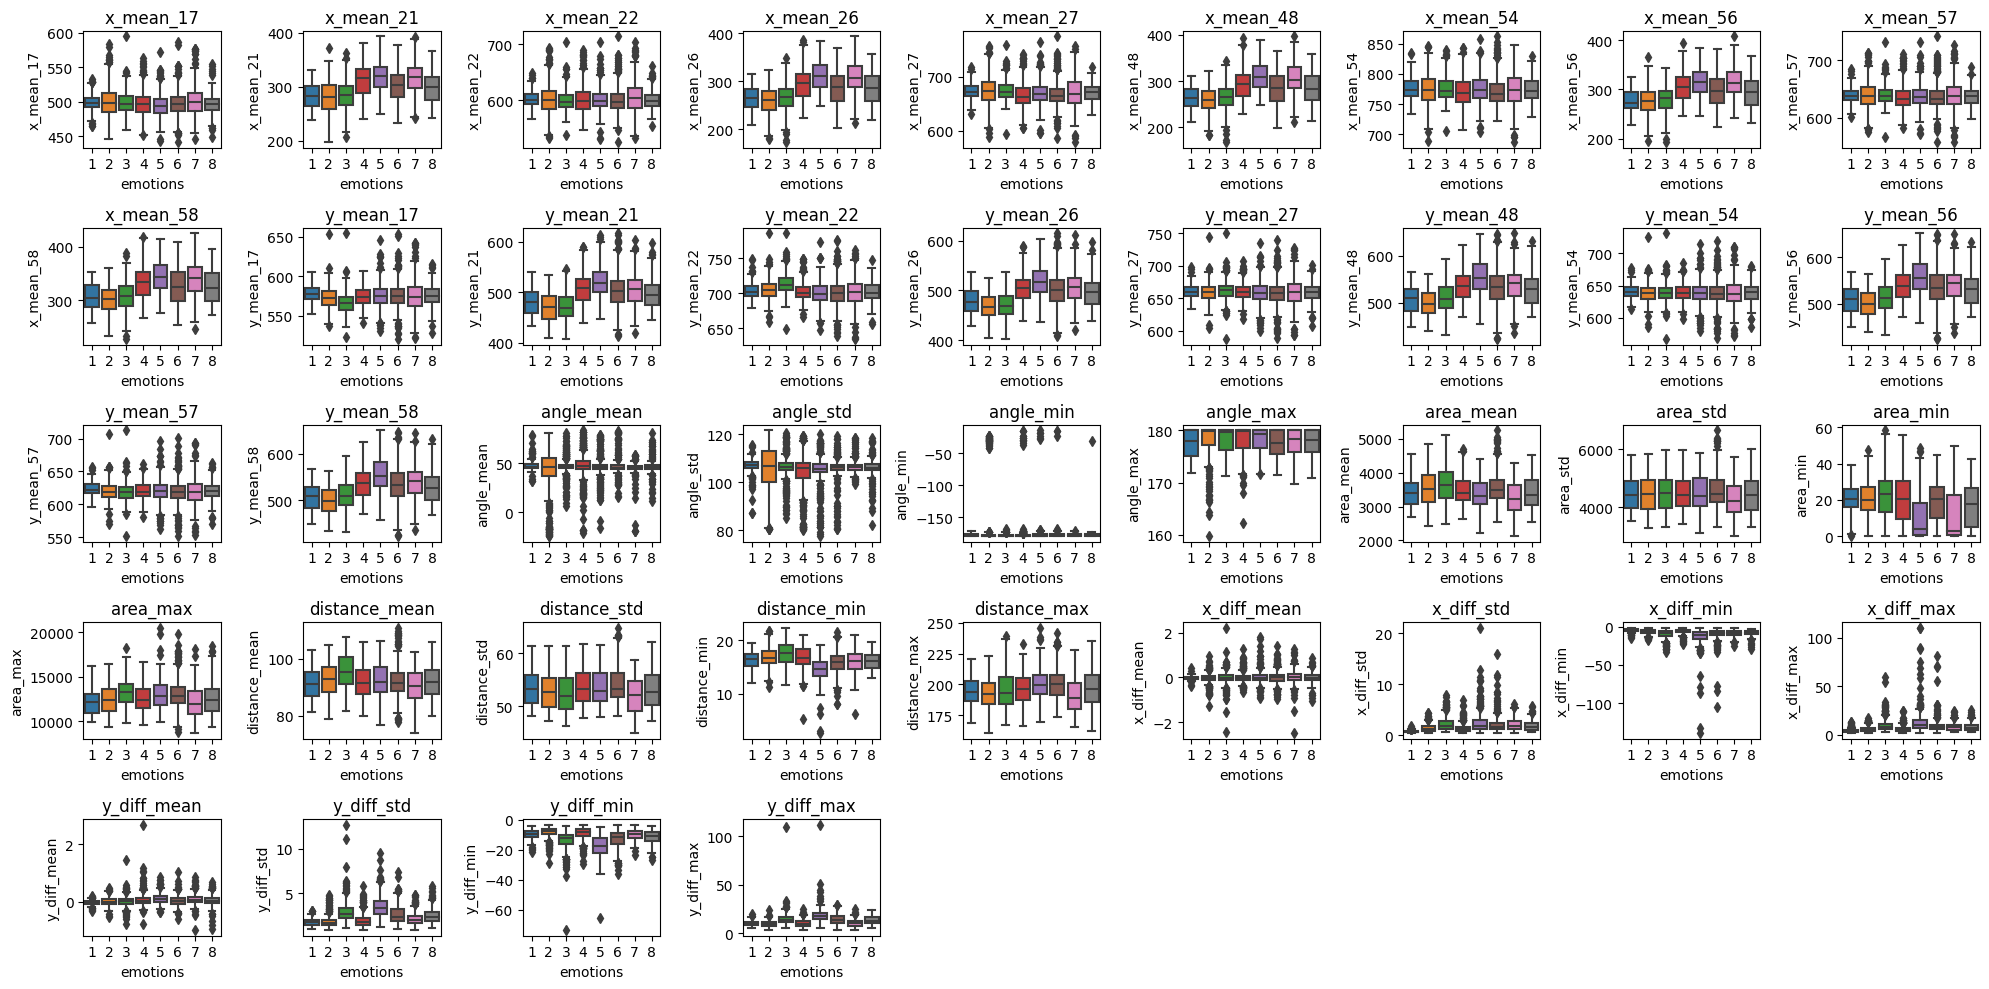

In [37]:
# boxplots para cada característica, separados por emoção
#(identificar características que têm variação significativa entre as emoções)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i, column in enumerate(final_features.columns[:-1], 1):
    plt.subplot(5, 9, i)
    sns.boxplot(x='emotions', y=column, data=final_features)
    plt.title(column)

plt.tight_layout()
plt.show()


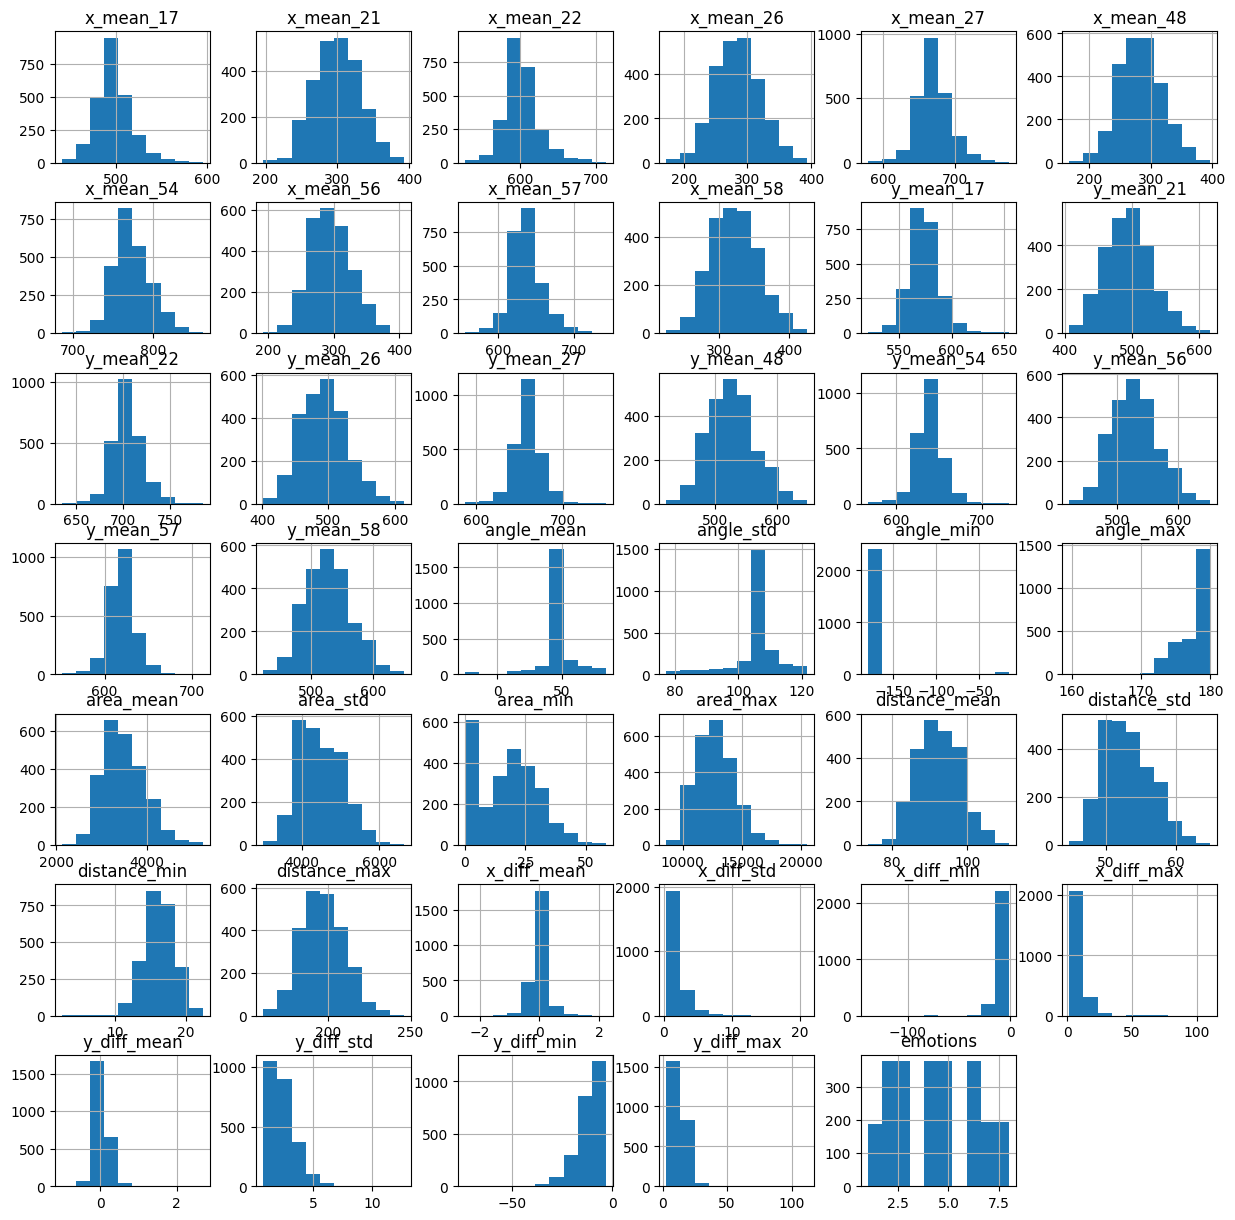

In [38]:
#visualizar primeiro as distribuições
final_features.hist(figsize=(15, 15))
plt.show()

In [39]:
#  aferir a gaussianidade da distribuição

from scipy.stats import kstest, f_oneway, kruskal

alpha = 0.05
results_df = pd.DataFrame()

for column in final_features.columns:
    feature_flat = final_features[column].ravel()

    # Verificação dos dados
    if np.any(np.isnan(feature_flat)):
        print(f"Feature {column} contains NaN values.")
        continue

    # Normalização dos dados
    normalized_feature = (feature_flat - np.mean(feature_flat)) / np.std(feature_flat)

    ks_statistic, p_value_ks = kstest(normalized_feature, 'norm')

    if p_value_ks < alpha:
        print(f"Distribution of {column} is not normal according to KS test.")
        # Se a distribuição não for normal, use Kruskal-Wallis
        h_statistic, p_value = kruskal(normalized_feature, emotions)
        test_used = "Kruskal-Wallis"
    else:
        print(f"Distribution of {column} is normal according to KS test.")
        # Se a distribuição for normal, use ANOVA
        f_statistic, p_value = f_oneway(normalized_feature, emotions)
        test_used = "ANOVA"

    if p_value < alpha:
        print(f"There is evidence to reject the null hypothesis (equality of means) for {column} using {test_used}.")
    else:
        print(f"There is no evidence to reject the null hypothesis (equality of means) for {column} using {test_used}.")

    results_df = pd.concat([results_df, pd.DataFrame({'p_value': [p_value], 'Test Used': [test_used]})], ignore_index=True)


Distribution of x_mean_17 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for x_mean_17 using Kruskal-Wallis.
Distribution of x_mean_21 is normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for x_mean_21 using ANOVA.
Distribution of x_mean_22 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for x_mean_22 using Kruskal-Wallis.
Distribution of x_mean_26 is normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for x_mean_26 using ANOVA.
Distribution of x_mean_27 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for x_mean_27 using Kruskal-Wallis.
Distribution of x_mean_48 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for x_mean_48 using Kruskal-Wallis.
Distribution of x_mean_54 is n

There is evidence to reject the null hypothesis (equality of means) for y_mean_17 using Kruskal-Wallis.
Distribution of y_mean_21 is normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for y_mean_21 using ANOVA.
Distribution of y_mean_22 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for y_mean_22 using Kruskal-Wallis.
Distribution of y_mean_26 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for y_mean_26 using Kruskal-Wallis.
Distribution of y_mean_27 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for y_mean_27 using Kruskal-Wallis.
Distribution of y_mean_48 is not normal according to KS test.
There is evidence to reject the null hypothesis (equality of means) for y_mean_48 using Kruskal-Wallis.
Distribution of y_mean_54 is not normal according to KS test.
There is evidence

In [40]:
final_features['emotions'] = emotions
for column in final_features.columns:
    if column != 'emotions':
        feature_flat = final_features[column].ravel()
        h_statistic_kw, p_value_kw = kruskal(feature_flat, emotions)
        f_statistic_anova, p_value_anova = f_oneway(feature_flat, emotions)

        print(f"Column: {column}, Kruskal-Wallis p-value: {p_value_kw}, ANOVA p-value: {p_value_anova}")


Column: x_mean_17, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_21, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_22, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_26, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_27, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_48, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_54, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_56, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_57, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: x_mean_58, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: y_mean_17, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: y_mean_21, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: y_mean_22, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: y_mean_26, Kruskal-Wallis p-value: 0.0, ANOVA p-value: 0.0
Column: y_mean_27, Kruskal-Wallis p-value: 0.0, ANOVA p-value:

Os valores de p-value sendo muito próximos de zero indicam que há evidências estatísticas significativas para rejeitar a hipótese nula de que as médias são iguais. No contexto de ANOVA e Kruskal-Wallis, isso significa que há diferenças estatisticamente significativas nas médias das features entre as diferentes expressões.

Portanto, com base nos resultados apresentados, posso concluir que as médias das features são diferentes entre as diferentes expressões. Isso sugere que essas features podem ser úteis para distinguir ou caracterizar as diferentes expressões.

### 4.3 a 4.4

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA()

final_features1, _, _ = getData(type='3d')
final_features_2d = final_features1.reshape(-1, final_features1.shape[-1])

# NaN-->zeros 
final_features_2d[np.isnan(final_features_2d)] = 0

# Normalizar ---> z-score
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(final_features_2d)

# Fit the PCA model to the data
pca.fit(final_features_scaled)

# Determinar nº de componentes para explicar 75% of the variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_75_percent = np.argmax(cumulative_explained_variance >= 0.75) + 1
print("O número de variáveis para explicar 75% do feature set é:",num_components_75_percent)

# Reduzir dimensionalidade para o nº de componentes
pca_result = pca.transform(final_features_scaled)
pca_result_75_percent = pca_result[:, :num_components_75_percent]


O número de variáveis para explicar 75% do feature set é: 3


Features relativas à compressão: [-5.621975 -3.938193  3.071516]


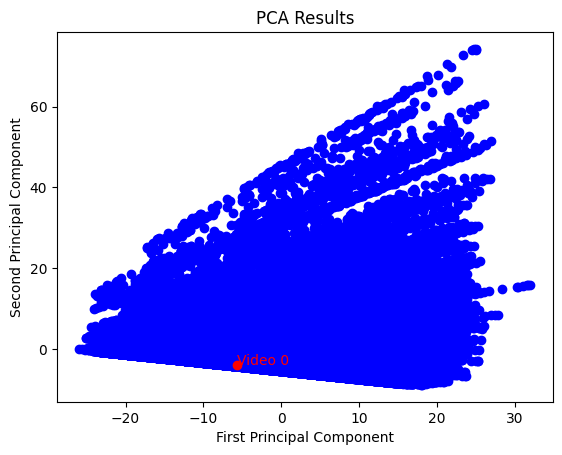

In [42]:
# Exemplo para o primeiro vídeo

video_features = pca_result_75_percent[0]
print("Features relativas à compressão:",video_features)

import matplotlib.pyplot as plt

plt.scatter(pca_result_75_percent[1:, 0], pca_result_75_percent[1:, 1], color='blue')
plt.scatter(video_features[0], video_features[1], color='red')
plt.annotate('Video 0', (video_features[0], video_features[1]), color='red')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Results')
plt.show()


Vantagens e Limitações do PCA:
* Vantagens:
    * Redução de Dimensionalidade: Permite representar os dados num espaço de menor dimensão.Ele transforma o conjunto original de variáveis num novo conjunto de variáveis(componentes principais), que são combinações lineares das variáveis originais.
    * Remoção de Correlações: As componentes principais são ortogonais, o que pode ajudar na remoção de correlações.
    * Filtragem de Ruídos: Pode ajudar a filtrar ruídos dos dados, retendo apenas os componentes que explicam a maior variância
    * Visualização: Pode auxiliar na visualização de dados de alta dimensionalidade,projetando-os nas duas ou três primeiras componentes principais.
    
* Limitações:
    * Perda de Informação: Quando os dados são projetados nas componentes principais, parte da variação nos dados é inevitavelmente perdida. A quantidade de informação perdida depende do número de componentes usados,se poucas componentes forem utilizadas, a perda de informação pode ser significativa.
    * Assunção de Linearidade: PCA assume que a relação entre as variáveis é linear.Se essa pressuposição não for atendida, os resultados do PCA podem não ser significativos
    * Dificuldade na Interpretação: As componentes principais não são facilmente interpretáveis, elas são combinações lineares das variáveis originais e não têm um significado físico ou conceitual claro.

### 4.5 a 4.6

In [43]:
from skfeature.function.similarity_based import fisher_score, reliefF

final_features3 = pd.concat([df, df1, df2], axis=1)
final_features_np = final_features3.values

# Normalizar usando z-score
scaler = StandardScaler()
final_features_normalized = scaler.fit_transform(final_features_np)

# Calcular Fisher Score
fisher_score_result = fisher_score.fisher_score(final_features_normalized, emotions)

# Calcular ReliefF
reliefF_result = reliefF.reliefF(final_features_normalized, emotions)

In [44]:
top_10_fisher_score_features_names = final_features3.columns[np.argsort(fisher_score_result)[-10:]]
print('Top 10 features according to fisher_score:', top_10_fisher_score_features_names)
print()
print("_______________________________________________________________________")
print()
top_10_reliefF_features_names = final_features3.columns[np.argsort(reliefF_result)[-10:]]
print('Top 10 features according to reliefF:', top_10_reliefF_features_names)


Top 10 features according to fisher_score: Index(['y_mean_17', 'y_diff_std', 'y_mean_21', 'x_diff_std', 'x_mean_17',
       'distance_min', 'x_mean_27', 'y_diff_mean', 'y_mean_22', 'x_diff_mean'],
      dtype='object')

_______________________________________________________________________

Top 10 features according to reliefF: Index(['x_diff_max', 'x_diff_mean', 'area_min', 'distance_mean',
       'distance_min', 'angle_min', 'distance_max', 'angle_max', 'area_max',
       'y_mean_48'],
      dtype='object')


In [45]:
indice_escolhido = 10 
features_instante = final_features3.iloc[indice_escolhido]

selected_features_fisher_score = features_instante[top_10_fisher_score_features_names]
selected_features_reliefF = features_instante[top_10_reliefF_features_names]

print(f"Características selecionadas no instante {indice_escolhido} usando Fisher Score:")
print(selected_features_fisher_score)
print()
print("_______________________________________________________________________")
print()
print(f"Características selecionadas no instante {indice_escolhido} usando ReliefF:")
print(selected_features_reliefF)


Características selecionadas no instante 10 usando Fisher Score:
y_mean_17       601.564880
y_diff_std        1.843387
y_mean_21       459.257477
x_diff_std        0.578048
x_mean_17       521.236206
distance_min     17.428738
x_mean_27       714.797852
y_diff_mean      -0.032150
y_mean_22       746.909546
x_diff_mean       0.004624
Name: 10, dtype: float32

_______________________________________________________________________

Características selecionadas no instante 10 usando ReliefF:
x_diff_max           3.200012
x_diff_mean          0.004624
area_min            17.314560
distance_mean      100.236488
distance_min        17.428738
angle_min         -176.837692
distance_max       206.422577
angle_max          178.126541
area_max         13982.066406
y_mean_48          481.538300
Name: 10, dtype: float32


Vantagens e Limitações do Fisher Score e ReliefF:
* Vantagens:
    * Seleção de Features Relevantes: Ambos os métodos são projetados para identificar features que são relevantes para a classificação.Essas características são aquelas que têm maior capacidade preditiva em relação à variável target.
    * Conseguem lidar com características categóricas, tornando-os adequados para uma ampla variedade de conjuntos de dados.
* Limitações:
    * Sensibilidade a Ruído: Pode ser sensível a ruídos nos dados.
    * Complexidade Computacional: Podem ser computacionalmente caros, especialmente para conjuntos de dados de alta dimensionalidade.
    * Dependência do Conjunto de Dados: A eficácia desses métodos pode depender do conjunto de dados específico.Se uma variável tiver uma escala maior do que as outras, ela dominará as pontuações e as outras variáveis terão menos influência.(importante normalizar)
    

# Parte B

## 1.1

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut

def data_split_tt(X, y, percent):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size = percent, random_state=42)
    return X_train, X_test, y_train, y_test

def data_split_loso(X, y, groups):
    logo = LeaveOneGroupOut()
    return logo.split(X,y,groups)


In [47]:
_, emotions, actors = getData(type='3d')

## 1.2

In [48]:
from sklearn import metrics

def matriz_conf(y_true, y_pred):
    return metrics.confusion_matriz(y_true,y_pred, normalize = 'all')

def accuracy(y_true,y_pred):
    return metrics.accuracy_score(y_true, y_pred)

def recall(y_true,y_pred):
    return metrics.recall_score(y_true, y_pred, average= 'weighted',zero_division=1)

def precision(y_true, y_pred):
    return metrics.precision_score(y_true, y_pred, average='weighted',zero_division=1)

def f1(y_true, y_pred):
    return metrics.f1_score(y_true,y_pred, average='weighted',zero_division=1)

## 2.1.1

In [49]:
from sklearn import svm

def svm_tt(X, y, reps, percent):
    
    accuracy_list = []
    recall_list = []
    precision_list = []
    f1_list = []
    
    for i in range(reps):
        X_train, X_test, y_train, y_test = data_split_tt(X,y, percent)
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy_list.append(accuracy(y_test, y_pred))
        recall_list.append(recall(y_test, y_pred))
        precision_list.append(precision(y_test, y_pred))
        f1_list.append(f1(y_test, y_pred))
        
    mean_accuracy = np.mean(accuracy_list)
    std_accuracy = np.std(accuracy_list)
    print(f'Mean value of accuracy_list = {mean_accuracy}')
    print(f'Standard Deviation of accuracy = {std_accuracy}')
    print()

    mean_recall = np.mean(recall_list)
    std_recall = np.std(recall_list)
    print(f'Mean value of recall_list = {mean_recall}')
    print(f'Standard Deviation of recall = {std_recall}')
    print()

    mean_precision = np.mean(precision_list)
    std_precision = np.std(precision_list)
    print(f'Mean value of precision_list = {mean_precision}')
    print(f'Standard Deviation of precision = {std_precision}')
    print()

    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)
    print(f'Mean value of f1_list = {mean_f1}')
    print(f'Standard Deviation of f1 = {std_f1}')
    print()
    
array_final_features = final_features.to_numpy()   
selected_features_fisher_score = final_features[top_10_fisher_score_features_names]
selected_features_reliefF = final_features[top_10_reliefF_features_names]

print('-- TRAIN-TEST SPLIT VALUES --')
print()
print('Values using all features: ')
svm_tt(array_final_features, emotions, 30, 0.30)
print("______________________________________________________________________________________")

print('Values using top10 fisher features: ')
svm_tt(selected_features_fisher_score, emotions, 30, 0.30)
print("______________________________________________________________________________________")

print('Values using top10 reliefF features: ')
svm_tt(selected_features_reliefF, emotions, 30, 0.30)
print("______________________________________________________________________________________")


-- TRAIN-TEST SPLIT VALUES --

Values using all features: 


Mean value of accuracy_list = 0.17255434782608695
Standard Deviation of accuracy = 0.0

Mean value of recall_list = 0.17255434782608695
Standard Deviation of recall = 0.0

Mean value of precision_list = 0.6819357391381408
Standard Deviation of precision = 2.220446049250313e-16

Mean value of f1_list = 0.09462054813885475
Standard Deviation of f1 = 2.7755575615628914e-17

______________________________________________________________________________________
Values using top10 fisher features: 
Mean value of accuracy_list = 0.20108695652173916
Standard Deviation of accuracy = 2.7755575615628914e-17

Mean value of recall_list = 0.20108695652173916
Standard Deviation of recall = 2.7755575615628914e-17

Mean value of precision_list = 0.5172922713848849
Standard Deviation of precision = 2.220446049250313e-16

Mean value of f1_list = 0.10164256354240565
Standard Deviation of f1 = 0.0

______________________________________________________________________________________
Values using top10 rel

## 2.1.2

In [50]:
def svm_loso(X,y,groups):
    
    accuracy_list = []
    recall_list = []
    precision_list = []
    f1_list = []
    
    for train_index, test_index in data_split_loso(X,y,groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # print("Conjunto de treinamento:", X_train, y_train)
        # print("Conjunto de teste:", X_test, y_test)
        # print("---")
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy_list.append(accuracy(y_test, y_pred))
        recall_list.append(recall(y_test, y_pred))
        precision_list.append(precision(y_test, y_pred))
        f1_list.append(f1(y_test, y_pred))
        
    mean_accuracy = np.mean(accuracy_list)
    std_accuracy = np.std(accuracy_list)
    print(f'Mean value of accuracy_list = {mean_accuracy}')
    print(f'Standard Deviation of accuracy = {std_accuracy}')
    print()

    mean_recall = np.mean(recall_list)
    std_recall = np.std(recall_list)
    print(f'Mean value of recall_list = {mean_recall}')
    print(f'Standard Deviation of recall = {std_recall}')
    print()

    mean_precision = np.mean(precision_list)
    std_precision = np.std(precision_list)
    print(f'Mean value of precision_list = {mean_precision}')
    print(f'Standard Deviation of precision = {std_precision}')
    print()

    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)
    print(f'Mean value of f1_list = {mean_f1}')
    print(f'Standard Deviation of f1 = {std_f1}')
    print()
        
        
selected_features_fisher_score = final_features[top_10_fisher_score_features_names]
selected_features_reliefF = final_features[top_10_reliefF_features_names]

array_final_features = final_features.to_numpy() 
array_selected_features_fisher_score = selected_features_fisher_score.to_numpy()
array_selected_features_reliefF = selected_features_reliefF.to_numpy()  

print('-- LOSO SPLIT VALUES --')
print()
print('Values using all features: ')
svm_loso(array_final_features, emotions, actors)
print("______________________________________________________________________________________")

print('Values using top10 fisher features: ')
svm_loso(array_selected_features_fisher_score, emotions, actors)
print("______________________________________________________________________________________")

print('Values using top10 reliefF features: ')
svm_loso(array_selected_features_reliefF, emotions, actors)
print("______________________________________________________________________________________")



-- LOSO SPLIT VALUES --

Values using all features: 
Mean value of accuracy_list = 0.21757478632478633
Standard Deviation of accuracy = 0.044634183408554365

Mean value of recall_list = 0.21757478632478633
Standard Deviation of recall = 0.044634183408554365

Mean value of precision_list = 0.6144205567111077
Standard Deviation of precision = 0.1555940844494112

Mean value of f1_list = 0.12957043513321206
Standard Deviation of f1 = 0.0540980617943017

______________________________________________________________________________________
Values using top10 fisher features: 
Mean value of accuracy_list = 0.2893429487179487
Standard Deviation of accuracy = 0.09335341688109797

Mean value of recall_list = 0.2893429487179487
Standard Deviation of recall = 0.09335341688109797

Mean value of precision_list = 0.552927387018191
Standard Deviation of precision = 0.08057845149519967

Mean value of f1_list = 0.21807086792941396
Standard Deviation of f1 = 0.09396731638109705

________________________

## 3.1)

In [51]:
import numpy as np
from scipy.fft import fft, rfft, rfftfreq, fftfreq

def dft_function(dataset, landmark=54, coordinate='x'):
    if coordinate.lower() == 'y':
        landmark += 68

    # Array to store the DFT results for each array
    dft_results_list = []

    # Calculate the DFT for each array in dataset
    for data in dataset:
        # Replace NaN values with 0s in the selected column
        data_column = data[landmark]
        data_column[np.isnan(data_column)] = 0

        # Calculate the DFT for the modified column
        dft_results = fft(data_column)
        dft_results_list.append(np.array(dft_results))

    # Accessing the first set of DFT results for demonstration
    return np.array(dft_results_list)


## 3.2)

Ao escolhermos axis=0, temos a média por sujeito

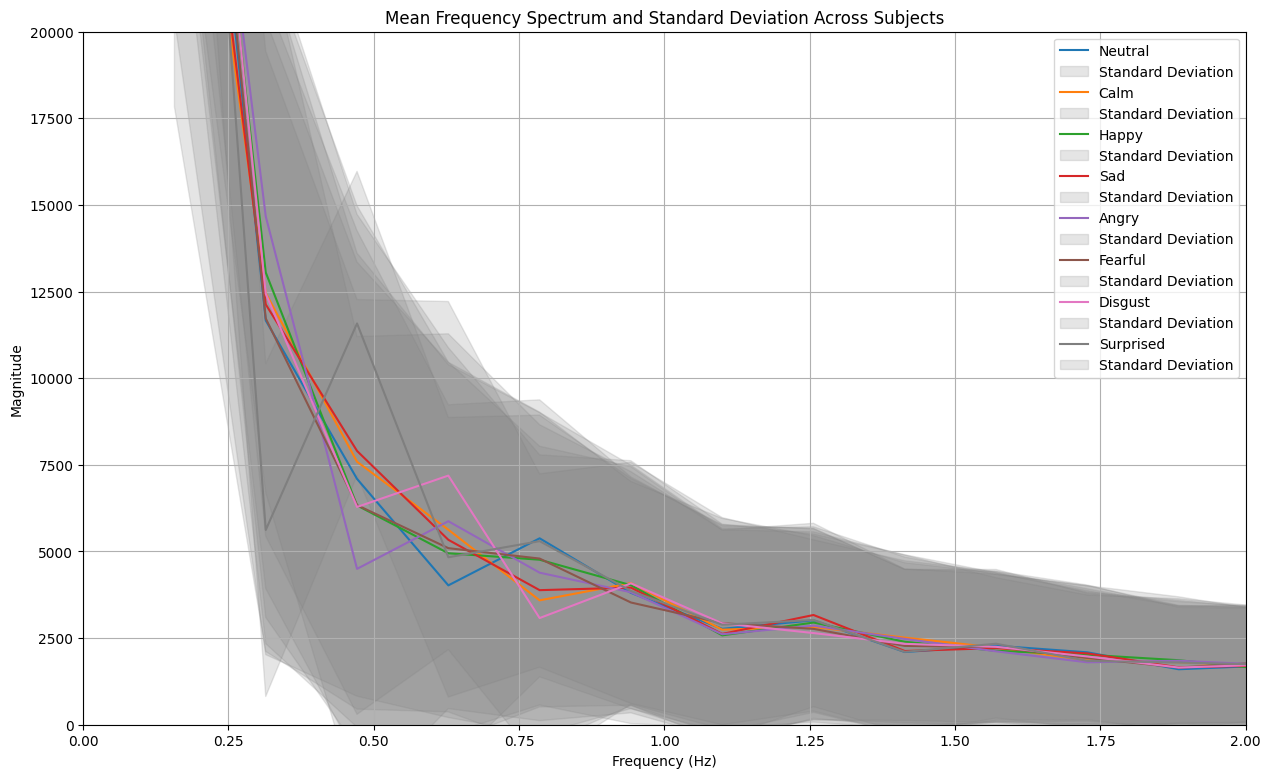

In [52]:
from scipy.signal import argrelextrema

set_emotions = set(np.load('emotions.npy'))
fig, ax = plt.subplots(figsize=(10*3/2, 6*3/2))
fs = 30
dft_dataset = dft_function(dataset)

minima = []
maxima = []

for i,emotion in enumerate(set_emotions):
    indices = np.where(emotions == emotion)[0]
    dft_dataset_chosen = dft_dataset[indices]
    mean_espetro = np.mean(dft_dataset_chosen, axis=0)
    std_espetro = np.std(dft_dataset_chosen, axis=0)

    frequencies = fftfreq(len(mean_espetro), 1/fs)
    
    positive_freq_indices = np.where(frequencies > 0)
    
    ax.plot(frequencies[positive_freq_indices], 
            np.abs(mean_espetro[positive_freq_indices]), 
            label=f'{emotion_names[i]}')
    
    ax.fill_between(frequencies[positive_freq_indices], 
                    (np.abs(mean_espetro) - np.abs(std_espetro))[positive_freq_indices], 
                    (np.abs(mean_espetro) + np.abs(std_espetro))[positive_freq_indices], 
                    color='gray', alpha=0.2, label='Standard Deviation')

    ax.set_xlim([0, 2])
    ax.set_ylim([0, 20_000])

    
    ax.set_title('Mean Frequency Spectrum and Standard Deviation Across Subjects')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ax.grid(True)
    
    # -- Para a extracao de features 3.3)
    y = np.abs(mean_espetro[positive_freq_indices])
    
    minima_indices = argrelextrema(y, np.less)[0][:1]
    maxima_indices = argrelextrema(y, np.greater)[0][:1]

    minima.append((y[minima_indices]))
    maxima.append((y[maxima_indices]))
    # ax.show()


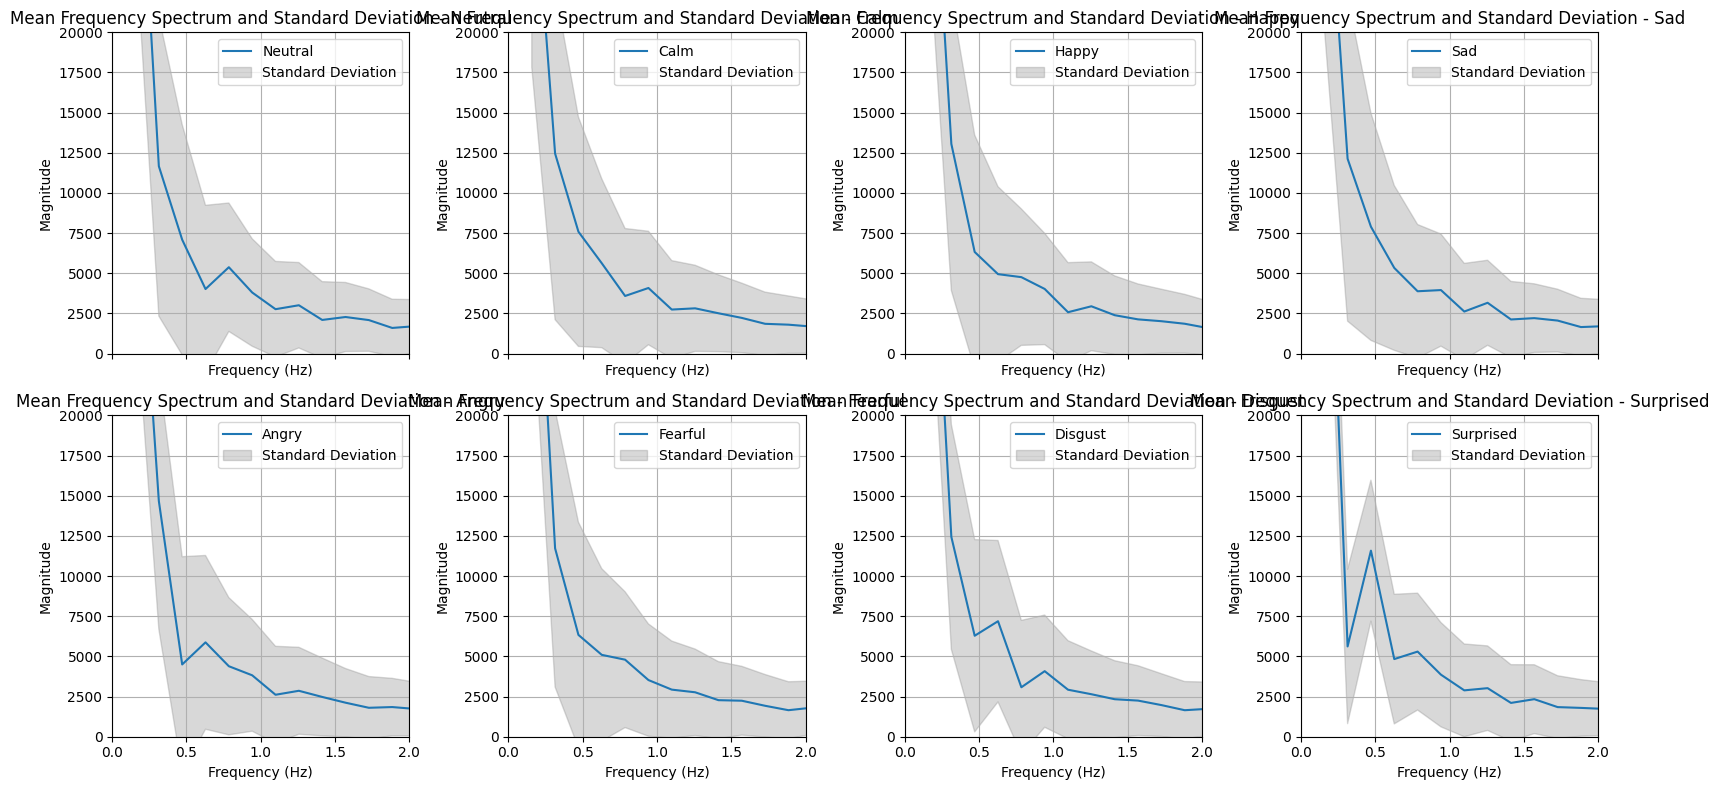

In [53]:
from scipy.signal import argrelextrema

set_emotions = set(np.load('emotions.npy'))
fig, axs = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
fs = 30
dft_dataset = dft_function(dataset)

minima = []
minimizer = []
maxima = []

for i, emotion in enumerate(set_emotions):
    indices = np.where(emotions == emotion)[0]
    dft_dataset_chosen = dft_dataset[indices]
    mean_espetro = np.mean(dft_dataset_chosen, axis=0)
    std_espetro = np.std(dft_dataset_chosen, axis=0)

    frequencies = fftfreq(len(mean_espetro), 1/fs)
    
    positive_freq_indices = np.where(frequencies > 0)
       
    row = i // 4
    col = i % 4
    
    ax = axs[row, col]
    ax.plot(frequencies[positive_freq_indices], np.abs(mean_espetro[positive_freq_indices]), label=f'{emotion_names[i]}')
    ax.fill_between(frequencies[positive_freq_indices], 
                    (np.abs(mean_espetro) - np.abs(std_espetro))[positive_freq_indices], 
                    (np.abs(mean_espetro) + np.abs(std_espetro))[positive_freq_indices], 
                    color='gray', alpha=0.3, label='Standard Deviation')

    ax.set_xlim([0, 2])
    ax.set_ylim([0, 20_000])

    ax.set_title(f'Mean Frequency Spectrum and Standard Deviation - {emotion_names[i]}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ax.grid(True)
    
    # -- Para a extracao de features 3.3)
    x = frequencies[positive_freq_indices]
    y = np.abs(mean_espetro[positive_freq_indices])
    
    minima_indices = argrelextrema(y, np.less)[0][:1]
    maxima_indices = argrelextrema(y, np.greater)[0][:1]
    
    minima.append(y[minima_indices][0])
    minimizer.append(x[minima_indices][0])
    maxima.append(y[maxima_indices][0])

plt.tight_layout()
plt.show()


#### 3.2.1 + 3.2.2)
Todos as emoções tendem a estabilidzar por volta da frequência 1.50Hz, por volta do valor 2000 de magnitude (valor absoluto da média do espetro)
- Nas emocoes 1,2,3,4,6 temos um desvio padrão alto e constante, bem como uma amplitude com poucas alterações. 
    - Uma vez que estamos a analisar uma emoção com poucos movimentos faciais, as poucas variações na magnitude ao longo da frquência são expectáveis, porém apesar de parecer confuso, o alto desvio padrão tamnbém é expectável
    - O desvio padrão alto é verificado devido a serem emoções com poucas alterações faciais, sendo as landmarks que as assinalam quase estacionárias até. Como estamos a analisar 25 sujeitos diferentes, então é normal as landmarks terem valores fixos diferentes uma vez que não é incomum as caras terem formatos diferentes. Para além de tar, as emoções são expressadas de maneira diferente para cada um. <p>
- No caso das emocoes 5, 7 e 8, **com especial atenção a 8**, já verificamos um desvio padrão menor e muito mais variação na magnitude.
    - Ao contrário das anteriormente explicadas, aqui estamos mais focados nas alterações de coordenadas das landmarks observadas, havendo na emoção quase nenhum desvio padrão a nível inicial, aumentando a partir da frequência 0.25 uma vez que o choque inicial da surpresa já foi passado

### 3.3)
Perante as anteriores observações, sugiro como duas novas features: 
- Frequência do Primeiro Mínimo Local 
- A diferenca entre o valor absoluto primeiro Minimo Local e primeiro Máximo Local

Analisando o gráfico que apresenta as diferentes emocoes, estas features demonstram-se importantes para delimitar se a emocao é surprised ou não.

In [54]:
feature1 = minimizer
feature2 = [maxima[i] - minima[i] for i in range(len(maxima))]

print('Feature 1 corresponde à Frequência do primeiro mínimo local')
print('Feature 2 corresponde à diferença entre o valor absoluto do primeiro mínimo e máximo local')

list_emotion = list(set_emotions)

df_feature_emotion = pd.DataFrame({'Emotion': list_emotion, 'Feature1': feature1, 'Feature2': feature2})
df_feature_emotion

Feature 1 corresponde à Frequência do primeiro mínimo local
Feature 2 corresponde à diferença entre o valor absoluto do primeiro mínimo e máximo local


,Emotion,Feature1,Feature2
0,1,0.628272,1357.976318
1,2,0.785340,496.805420
2,3,1.099476,369.869385
3,4,0.785340,74.082520
4,5,0.471204,1375.227539
5,6,1.884817,156.362305
6,7,0.471204,905.372070
7,8,0.314136,5961.432129


## 4

### 4.1)

In [55]:
dataset_test, _, _ = getData(type='3d')

def discard_samples(dataset):
    min_sample = min(np.load('frames.npy'))
    return np.array([data[:, :min_sample] for data in dataset])

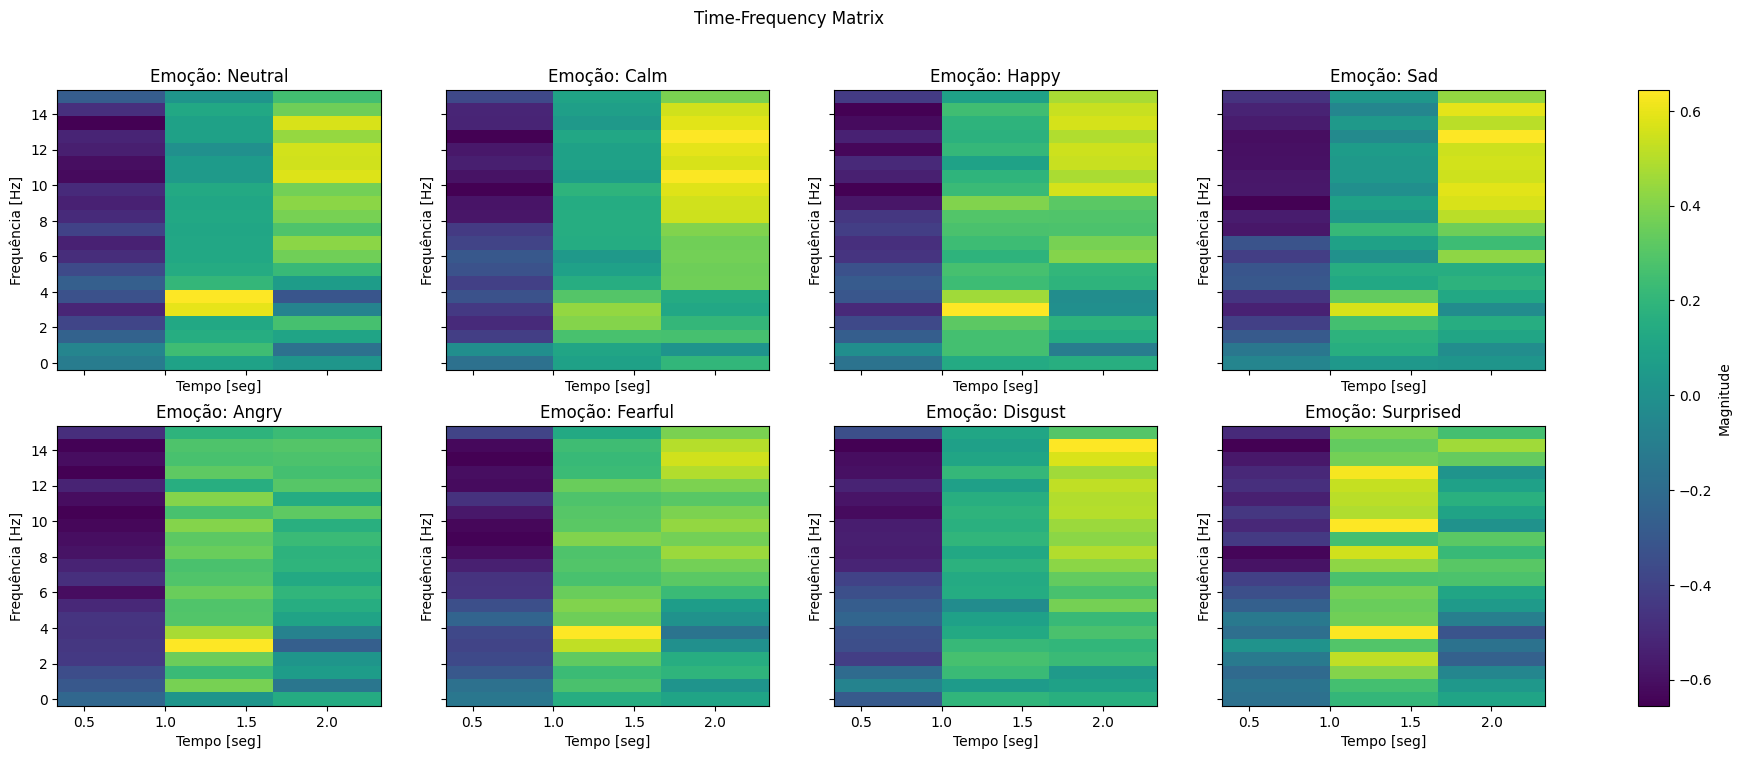

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram,stft
from scipy.stats import zscore as zscore_norm

def stft_function(dataset, landmark=54, coordinate='x', fs=30, nperseg=40, noverlap=20):
    dataset = discard_samples(dataset)
    
    column_dataset = np.array([data[landmark] for data in dataset])
    
    emotion_sum = []
    emotion_count = []
    
    if coordinate.lower() == 'y':
        landmark += 68
    
    set_emotions = set(np.load('emotions.npy'))
    set_actors = set(np.load('actors.npy'))
    nr_frames = min(np.load('frames.npy'))

    fig, axs = plt.subplots(2, 4, figsize=(24, 8), sharex=True, sharey=True)
    plt.suptitle('Time-Frequency Matrix',x=0.43)

    mappable = None  # Variable to store the mappable for colorbar

    for i, emotion in enumerate(set_emotions):
        emotion_indices = np.where(emotions == emotion)[0]
        actor_stfts = {actor: [] for actor in set_actors}
        
        for actor in set_actors:
            actor_indices = np.where(actors == actor)[0]
            indices = np.intersect1d(emotion_indices, actor_indices)
            
            for index in indices:
                frequencies, times, Sxx = spectrogram(column_dataset[index], 
                                                      fs=fs, 
                                                      nperseg=nperseg, 
                                                      noverlap=noverlap)
                tf = np.abs(Sxx)
                
                # Normalizazaco pelo Z-Score
                tf_norm = zscore_norm(tf, axis=1)
                
                actor_stfts[actor].append(tf_norm)
        
        if actor_stfts:
            mean_emotion_stfts = np.mean([np.mean(stfts, axis=0) for stfts in actor_stfts.values()], axis=0)

            row = i // 4
            col = i % 4

            pcm = axs[row, col].pcolormesh(times, frequencies, mean_emotion_stfts)
            axs[row, col].set_title(f'Emoção: {emotion_names[i]}')
            axs[row, col].set_ylabel('Frequência [Hz]')
            axs[row, col].set_xlabel('Tempo [seg]')
            
            emotion_sum.append(np.sum(mean_emotion_stfts[:,1]))
            emotion_count.append(np.sum(mean_emotion_stfts[:,1] <0 ))
            # print(f'Sum of Negative Values for {emotion_names[i]}: {sum_values}')
            # print(f'Count of Negative Values for {emotion_names[i]}: {count_values}')
            # print(mean_emotion_stfts)
            # print()


            # Set mappable for the colorbar on the first iteration
            if mappable is None:
                mappable = pcm

        else:
            print(f"Não há dados para a emoção {emotion}")

    plt.colorbar(mappable, ax=axs, label='Magnitude')
    plt.show()
    return emotion_sum, emotion_count

emotion_sum, emotion_count = stft_function(dataset_test)


### 4.2)

Após analisar cautelosamente o espectrograma, conseguimos visualizar 3 distintas colunas. Em 0.6, em 1.3 e em 2.
- Na primeira coluna os resultados são muito parecidos visualmente, então podemos descrebilizá-la.
- Apesar de na terceira coluna termos alguns resultados diferentes, é na segunda coluna que as verdadeiras diferenças se notam.

Em primeiro, podemos analisar que as emoções Neutral e Calm têm imensas frequências com magnitude perto de 0, o que é expectável uma vez que, tal como o nome da emoção indica, existe pouca alteração nas expressões faciais, sendo portanto neutras.
Porém, a emoção onde se nota mais diferenças visuais é a *Sad*. Nesta conseguimos ver, muitos valores negativos.
Na *Surprised* podemos também identificar imensos valores positivos, porém, no exercício 3) já foram definidas 2 features que ajudam na caraterização desta emoção.

### 4.3)

Tendo em conta a análise previamente feita, podemos definir como 2 features:
- A soma de frequências para cada emoção
- A contagem de frequências com valor negativo

Ao verificarmos os valores numéricos, conseguimos-nos aperceber que a emoção *Sad* tem a soma mais baixa, bem como o maior número de frequências com valor negativo.

In [57]:
feature3, feature4 = emotion_sum, emotion_count

list_emotion = list(set_emotions)

df_4feature_emotion = pd.DataFrame({'Emotion': list_emotion, 'Feature 3': feature3, 'Feature 4': feature4})
df_4feature_emotion

,Emotion,Feature 3,Feature 4
0,1,3.333402,1
1,2,2.195763,0
2,3,3.711329,0
3,4,1.931618,4
4,5,5.877322,0
5,6,4.726846,0
6,7,2.428465,1
7,8,6.506998,0


## 5

### 5.1)

Considerando:
- feature1 e feature2 como as features do exercício 3
- feature3 e feature4 como as features do exercício 4

In [58]:
final_features['feature1'] = final_features['emotions'].apply(lambda x: feature1[int(x) - 1])
final_features['feature2'] = final_features['emotions'].apply(lambda x: feature2[int(x) - 1])

final_features['feature3'] = final_features['emotions'].apply(lambda x: feature3[int(x) - 1])
final_features['feature4'] = final_features['emotions'].apply(lambda x: feature4[int(x) - 1])


In [59]:
final_features

,x_mean_17,x_mean_21,x_mean_22,x_mean_26,x_mean_27,x_mean_48,x_mean_54,x_mean_56,x_mean_57,x_mean_58,...,x_diff_max,y_diff_mean,y_diff_std,y_diff_min,y_diff_max,emotions,feature1,feature2,feature3,feature4
0,499.956116,276.903076,596.393860,263.701019,659.689758,261.963257,761.264282,266.878540,626.623474,290.180603,...,2.100037,0.100618,1.329715,-9.899994,10.600006,1,0.628272,1357.976318,3.333402,1
1,492.957794,312.977997,597.442261,302.270630,666.654114,300.211945,762.766052,300.149536,635.366028,338.501831,...,5.099976,0.137778,1.830958,-7.700012,10.700012,1,0.628272,1357.976318,3.333402,1
2,519.741760,299.641724,630.262146,292.758240,689.424316,295.291260,799.791260,311.918457,658.114563,330.068939,...,3.500000,-0.104804,1.971355,-10.200012,13.000000,1,0.628272,1357.976318,3.333402,1
3,511.977814,253.958588,609.078796,242.596985,673.572693,248.182831,765.487854,267.806061,640.437378,290.918152,...,5.099976,-0.089796,1.863839,-10.600006,13.199982,1,0.628272,1357.976318,3.333402,1
4,505.012939,269.983337,618.141724,246.688889,684.894470,249.296295,801.500000,272.484253,652.584290,293.712036,...,2.200012,-0.023084,1.201324,-6.500000,6.400024,1,0.628272,1357.976318,3.333402,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,510.821594,267.239990,616.246399,236.573593,676.740784,233.750412,767.793579,257.735992,652.305603,285.917572,...,21.000000,0.346129,4.277780,-18.399994,19.000000,6,1.884817,156.362305,4.726846,0
2448,508.563507,320.788116,597.317444,307.973846,664.757141,309.262726,758.628601,330.293640,630.674622,350.262665,...,8.399963,0.002720,2.254977,-10.100037,14.800049,6,1.884817,156.362305,4.726846,0
2449,474.504242,281.571442,570.789307,250.505722,635.409973,246.725723,756.304993,267.442871,602.664307,294.477142,...,6.199951,-0.282086,2.305253,-12.000000,10.699997,6,1.884817,156.362305,4.726846,0
2450,551.355347,267.336151,646.064575,235.476593,706.678040,233.317734,818.460327,261.033325,675.893616,278.703583,...,12.200012,0.001071,2.629477,-13.299988,11.299988,6,1.884817,156.362305,4.726846,0


### 5.2)

In [60]:
if 'emotions' in final_features.columns:
    final_features5 = final_features.drop('emotions', axis=1)
    
# Normalizar usando z-score
final_features5_array = final_features5.to_numpy()
scaler = StandardScaler()
final_features5_normalized = scaler.fit_transform(final_features5_array)

# Calcular Fisher Score
fisher_score_result = fisher_score.fisher_score(final_features5_normalized, emotions)

# Calcular ReliefF
reliefF_result = reliefF.reliefF(final_features5_normalized, emotions)


In [61]:
print('Values using Train-Test split: ')
print()
svm_tt(final_features5_array, emotions, 30, 0.30)

Values using Train-Test split: 

Mean value of accuracy_list = 0.4089673913043478
Standard Deviation of accuracy = 5.551115123125783e-17

Mean value of recall_list = 0.4089673913043478
Standard Deviation of recall = 5.551115123125783e-17

Mean value of precision_list = 0.6002779121932076
Standard Deviation of precision = 0.0

Mean value of f1_list = 0.3195368631275138
Standard Deviation of f1 = 0.0



In [62]:
print('Values using LOSO split: ')
print()
svm_loso(final_features5_array, emotions, actors)

Values using LOSO split: 

Mean value of accuracy_list = 0.5186431623931623
Standard Deviation of accuracy = 0.08219595216096294

Mean value of recall_list = 0.5186431623931623
Standard Deviation of recall = 0.08219595216096294

Mean value of precision_list = 0.6528354715201884
Standard Deviation of precision = 0.08726385022912574

Mean value of f1_list = 0.4304920907222854
Standard Deviation of f1 = 0.09974843858878125



In [63]:
top_10_fisher_score_features_names = final_features5.columns[np.argsort(fisher_score_result)[-10:]]
print('Top 10 features according to fisher_score:\n', top_10_fisher_score_features_names)
print()
print("______________________________________________________________________________________")
print()
top_10_reliefF_features_names = final_features5.columns[np.argsort(reliefF_result)[-10:]]
print('Top 10 features according to reliefF:\n', top_10_reliefF_features_names)

Top 10 features according to fisher_score:
 Index(['y_mean_17', 'y_diff_std', 'y_mean_21', 'x_diff_std', 'x_mean_17',
       'distance_min', 'x_mean_27', 'y_diff_mean', 'y_mean_22', 'x_diff_mean'],
      dtype='object')

______________________________________________________________________________________

Top 10 features according to reliefF:
 Index(['y_diff_max', 'y_diff_mean', 'distance_min', 'x_diff_mean',
       'x_diff_min', 'area_min', 'x_diff_max', 'area_max', 'distance_max',
       'y_mean_58'],
      dtype='object')


### 5.3)

Usando a abordagem do tempo e de tempo-frequência notamos um ligeiro aumento na classificação usando SVMs, porém ainda assim, as top10 features continuam a ser as definidas previamente no ponto A4, visto que o aumento não foi significativo